# Clasificación de Fugas con Escalogramas CWT

## 1. Instalación de Dependencias e Importación de Librerías

In [1]:
# Instalación de dependencias para wavelet denoising
!pip install PyWavelets

# Instalación de dependencias para fCWT
!git clone https://github.com/fastlib/fCWT.git
!pip install fCWT
!apt-get update
!apt-get install libfftw3-single3 -y

# Importación de bibliotecas necesarias
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import matplotlib.cm as cm
import scipy.signal as sig
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
import h5py
from tqdm import tqdm
import random
import pywt
import fcwt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import sys
import time
import datetime


# Importar la clase WaveletDenoising
from denoising import WaveletDenoising

# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

# Configuraciones globales para visualización
plt.style.use('seaborn-v0_8-whitegrid')

fatal: destination path 'fCWT' already exists and is not an empty directory.
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry miss

## 2. Cargar y Visualizar Datos

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


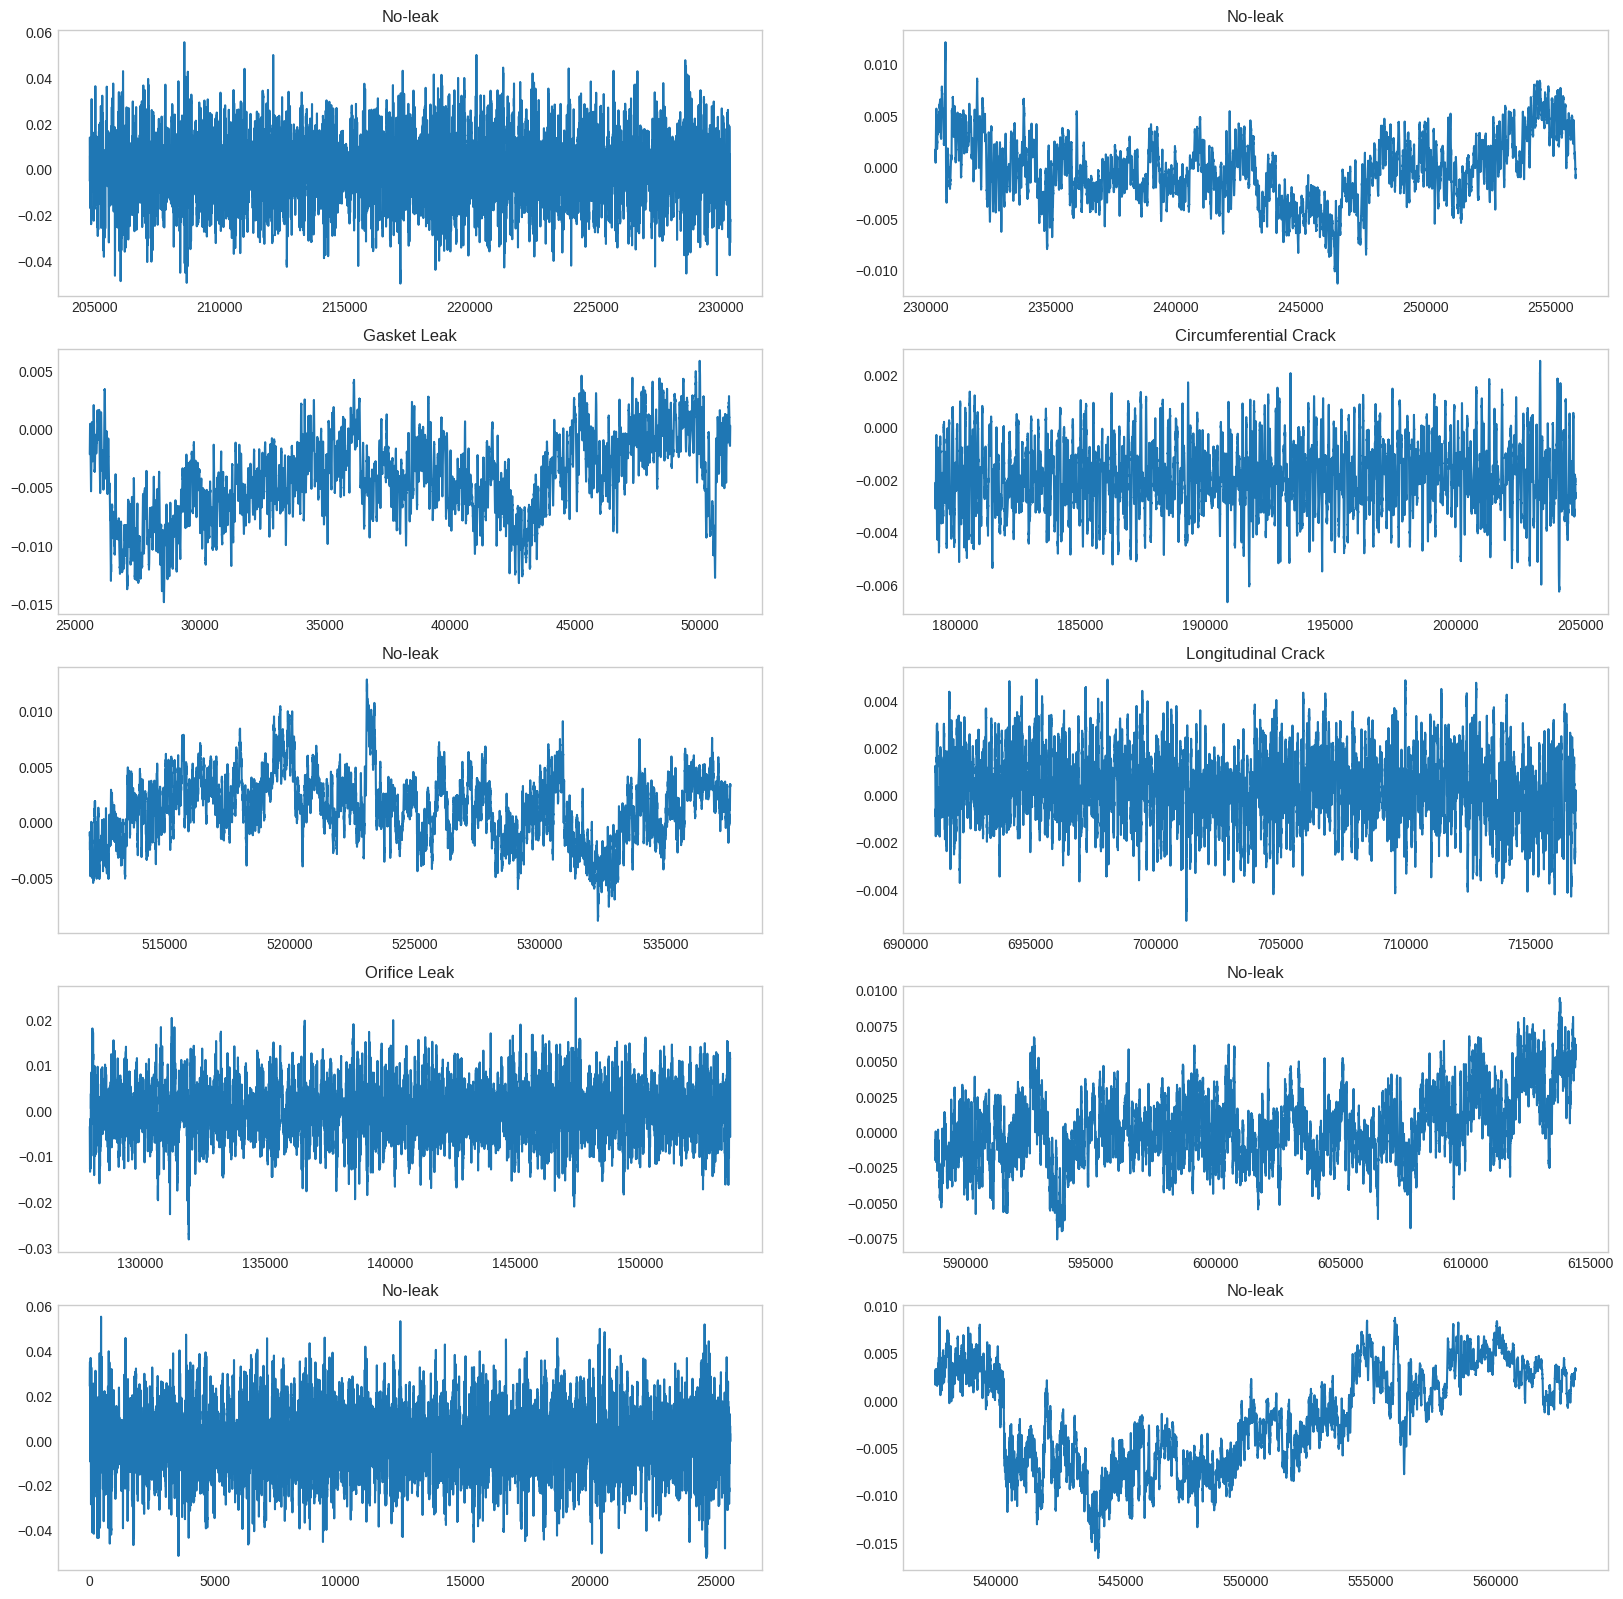

In [2]:
# Cambiando la ruta para acceder a los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # in Hz
signal_sr = 25600  # in Hz
downsample_factor = original_sr//signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Definir diccionarios de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {'Circumferential Crack': 0, 'Gasket Leak': 1, 'Longitudinal Crack': 2, 'No-leak': 3, 'Orifice Leak': 4}
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Esta función elimina el archivo .DS_Store si existe en la ruta definida
def remove_DS_store_file(path):
    # Buscar tanto .DS_Store como .DS_store (diferencias de capitalización)
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    """
    Carga datos de acelerómetro con opción para clasificación binaria o multiclase

    Args:
        data_dir: Directorio donde se encuentran los datos
        sample_rate: Tasa de muestreo deseada
        downsample_factor: Factor de submuestreo
        label_codes: Diccionario de códigos de etiquetas
        mode: 'five_classes' o 'binary'
        fraction_to_include: Fracción de frames a incluir

    Returns:
        signals: Lista de señales
        labels: Lista de etiquetas
    """
    # Eliminar .DS_Store si existe en data_dir
    remove_DS_store_file(data_dir)

    signals = []
    labels = []

    # Para el modo binario, necesitamos contabilizar cuántos frames hay por cada tipo de fuga
    leak_counts = {
        'Circumferential Crack': 0,
        'Gasket Leak': 0,
        'Longitudinal Crack': 0,
        'Orifice Leak': 0
    }
    leak_signals = {
        'Circumferential Crack': [],
        'Gasket Leak': [],
        'Longitudinal Crack': [],
        'Orifice Leak': []
    }
    no_leak_signals = []
    no_leak_labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)

        # Verificar que sea un directorio antes de procesarlo
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        # Eliminar .DS_Store si existe
        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)

            # Verificar que sea un archivo
            if not os.path.isfile(file_path):
                continue

            # Cargar el archivo csv
            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)

            # Submuestrear seleccionando cada n-ésima fila
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :]
            accelerometer_signal_df = accelerometer_signal_df.reset_index(drop=True)

            # Obtener 30 segundos de datos
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate*30)]

            # Generar un vector con el índice de inicio para cada frame de 1 segundo
            sample_indexes = np.linspace(0,len(accelerometer_signal)-sample_rate,len(accelerometer_signal)//sample_rate)

            # Obtener el número de frames de señal
            signal_frames_number = fraction_to_include*len(sample_indexes)
            signal_frames_counter = 0

            # Generar frames de señal de 1 segundo a partir de la señal original
            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame+sample_rate)]
                signal_frames_counter+=1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    # Guardar directamente para clasificación de 5 clases
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # modo binario
                    # Para modo binario, guardamos las señales según su tipo
                    if label == 'No-leak':
                        no_leak_signals.append(accelerometer_signal_frame)
                        no_leak_labels.append(1)  # 1 para No-leak en modo binario
                    else:
                        # Guardar en la categoría correspondiente
                        leak_signals[label].append(accelerometer_signal_frame)
                        leak_counts[label] += 1

    # Si estamos en modo binario, equilibramos el dataset
    if mode == 'binary':
        # Encontrar la cantidad mínima de ejemplos por tipo de fuga
        min_count_per_leak_type = min(leak_counts.values()) if leak_counts else 0

        # Calcular cuántos ejemplos necesitamos de cada tipo para equilibrar con No-leak
        if len(no_leak_signals) > 0 and len(leak_counts) > 0:
            total_leak_samples_needed = len(no_leak_signals)
            samples_per_leak_type = total_leak_samples_needed // len(leak_counts)

            # Asegurar que no tomamos más muestras de las disponibles
            samples_per_leak_type = min(samples_per_leak_type, min_count_per_leak_type)

            # Seleccionar muestras equilibradas de cada tipo de fuga
            balanced_leak_signals = []
            for leak_type in leak_signals:
                if leak_signals[leak_type]:
                    # Tomar una muestra aleatoria del tamaño necesario
                    selected_signals = random.sample(leak_signals[leak_type],
                                                    min(samples_per_leak_type, len(leak_signals[leak_type])))
                    balanced_leak_signals.extend(selected_signals)

            # Crear etiquetas para las señales de fuga (0 para Leak en modo binario)
            balanced_leak_labels = [0] * len(balanced_leak_signals)

            # Combinar todo
            signals = balanced_leak_signals + no_leak_signals
            labels = balanced_leak_labels + no_leak_labels

            print(f"Modo binario: {len(balanced_leak_labels)} muestras de fuga, {len(no_leak_labels)} muestras sin fuga")

    return signals, labels

# Cargar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode=classification_mode,
    fraction_to_include=1
)

signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

# Generar diccionarios con subconjuntos de entrenamiento y prueba a partir de los datos cargados
signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
    signals_lst,
    labels_lst,
    test_size=0.2,
    random_state=53
)

# Imprimir información sobre el dataset resultante:
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][np.random.randint(0,len(signals_dict["training"]))])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i+1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 3. Normalización y Denoising con Wavelet

Denoising testing signals: 100%|██████████| 240/240 [00:00<00:00, 244.58it/s]


Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


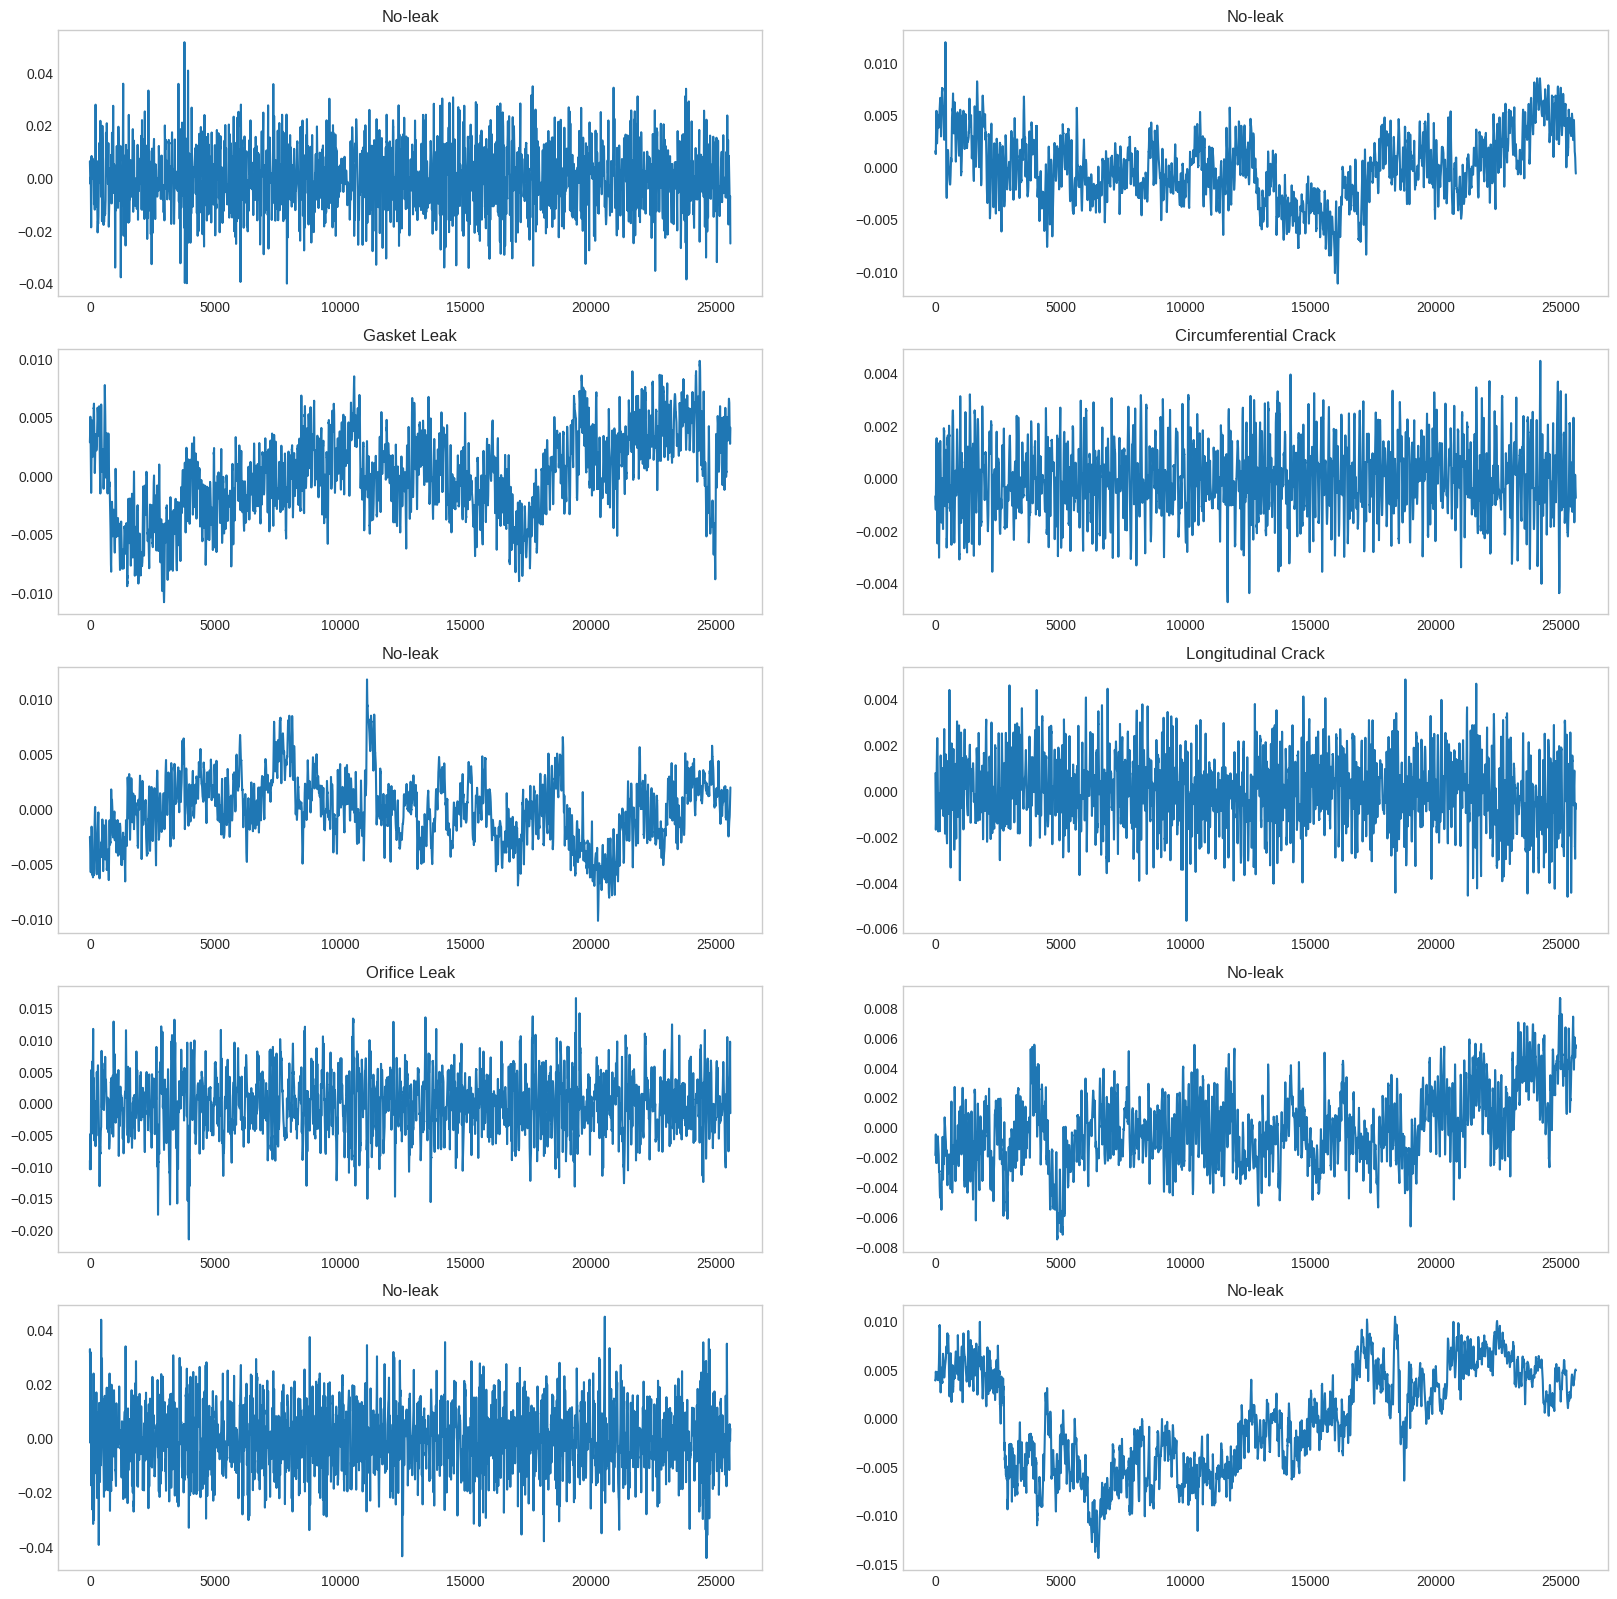

In [3]:
def wavelet_denoise(signals_dict, labels_dict):
    """
    Normaliza y aplica denoising wavelet a las señales

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba
        labels_dict: Diccionario con etiquetas de entrenamiento y prueba

    Returns:
        wavelet_denoised_signals: Diccionario con señales procesadas
        labels_dict: Diccionario con etiquetas
    """
    # Crear un objeto de la clase WaveletDenoising
    wd = WaveletDenoising(normalize=True,
                      wavelet='sym3',
                      level=4,
                      thr_mode='soft',
                      method="universal")

    # Crear un nuevo diccionario para almacenar los coeficientes calculados:
    wavelet_denoised_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal_element in tqdm(signals_subset, desc=f"Denoising {key} signals"):
            # Denoising de la señal usando el método wavelet denoising
            denoised_signal = wd.fit(signal_element)

            # Almacenar las señales denoised en el nuevo diccionario
            wavelet_denoised_signals[key].append(denoised_signal)

    return wavelet_denoised_signals, labels_dict

# Denoising de las señales en los diccionarios de entrenamiento y prueba
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Imprimir información sobre el dataset resultante:
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 3.2  Normalización de señales post-wavelet denoising

Normalizando señales procesadas con wavelet denoising...


Normalizando testing signals: 100%|██████████| 240/240 [00:00<00:00, 5303.76it/s]


Number of signals (training, testing): (960, 240)
Number of samples per signal: 25600
Rango de valores en training: [0.0000, 1.0000]
Rango de valores en testing: [0.0000, 1.0000]


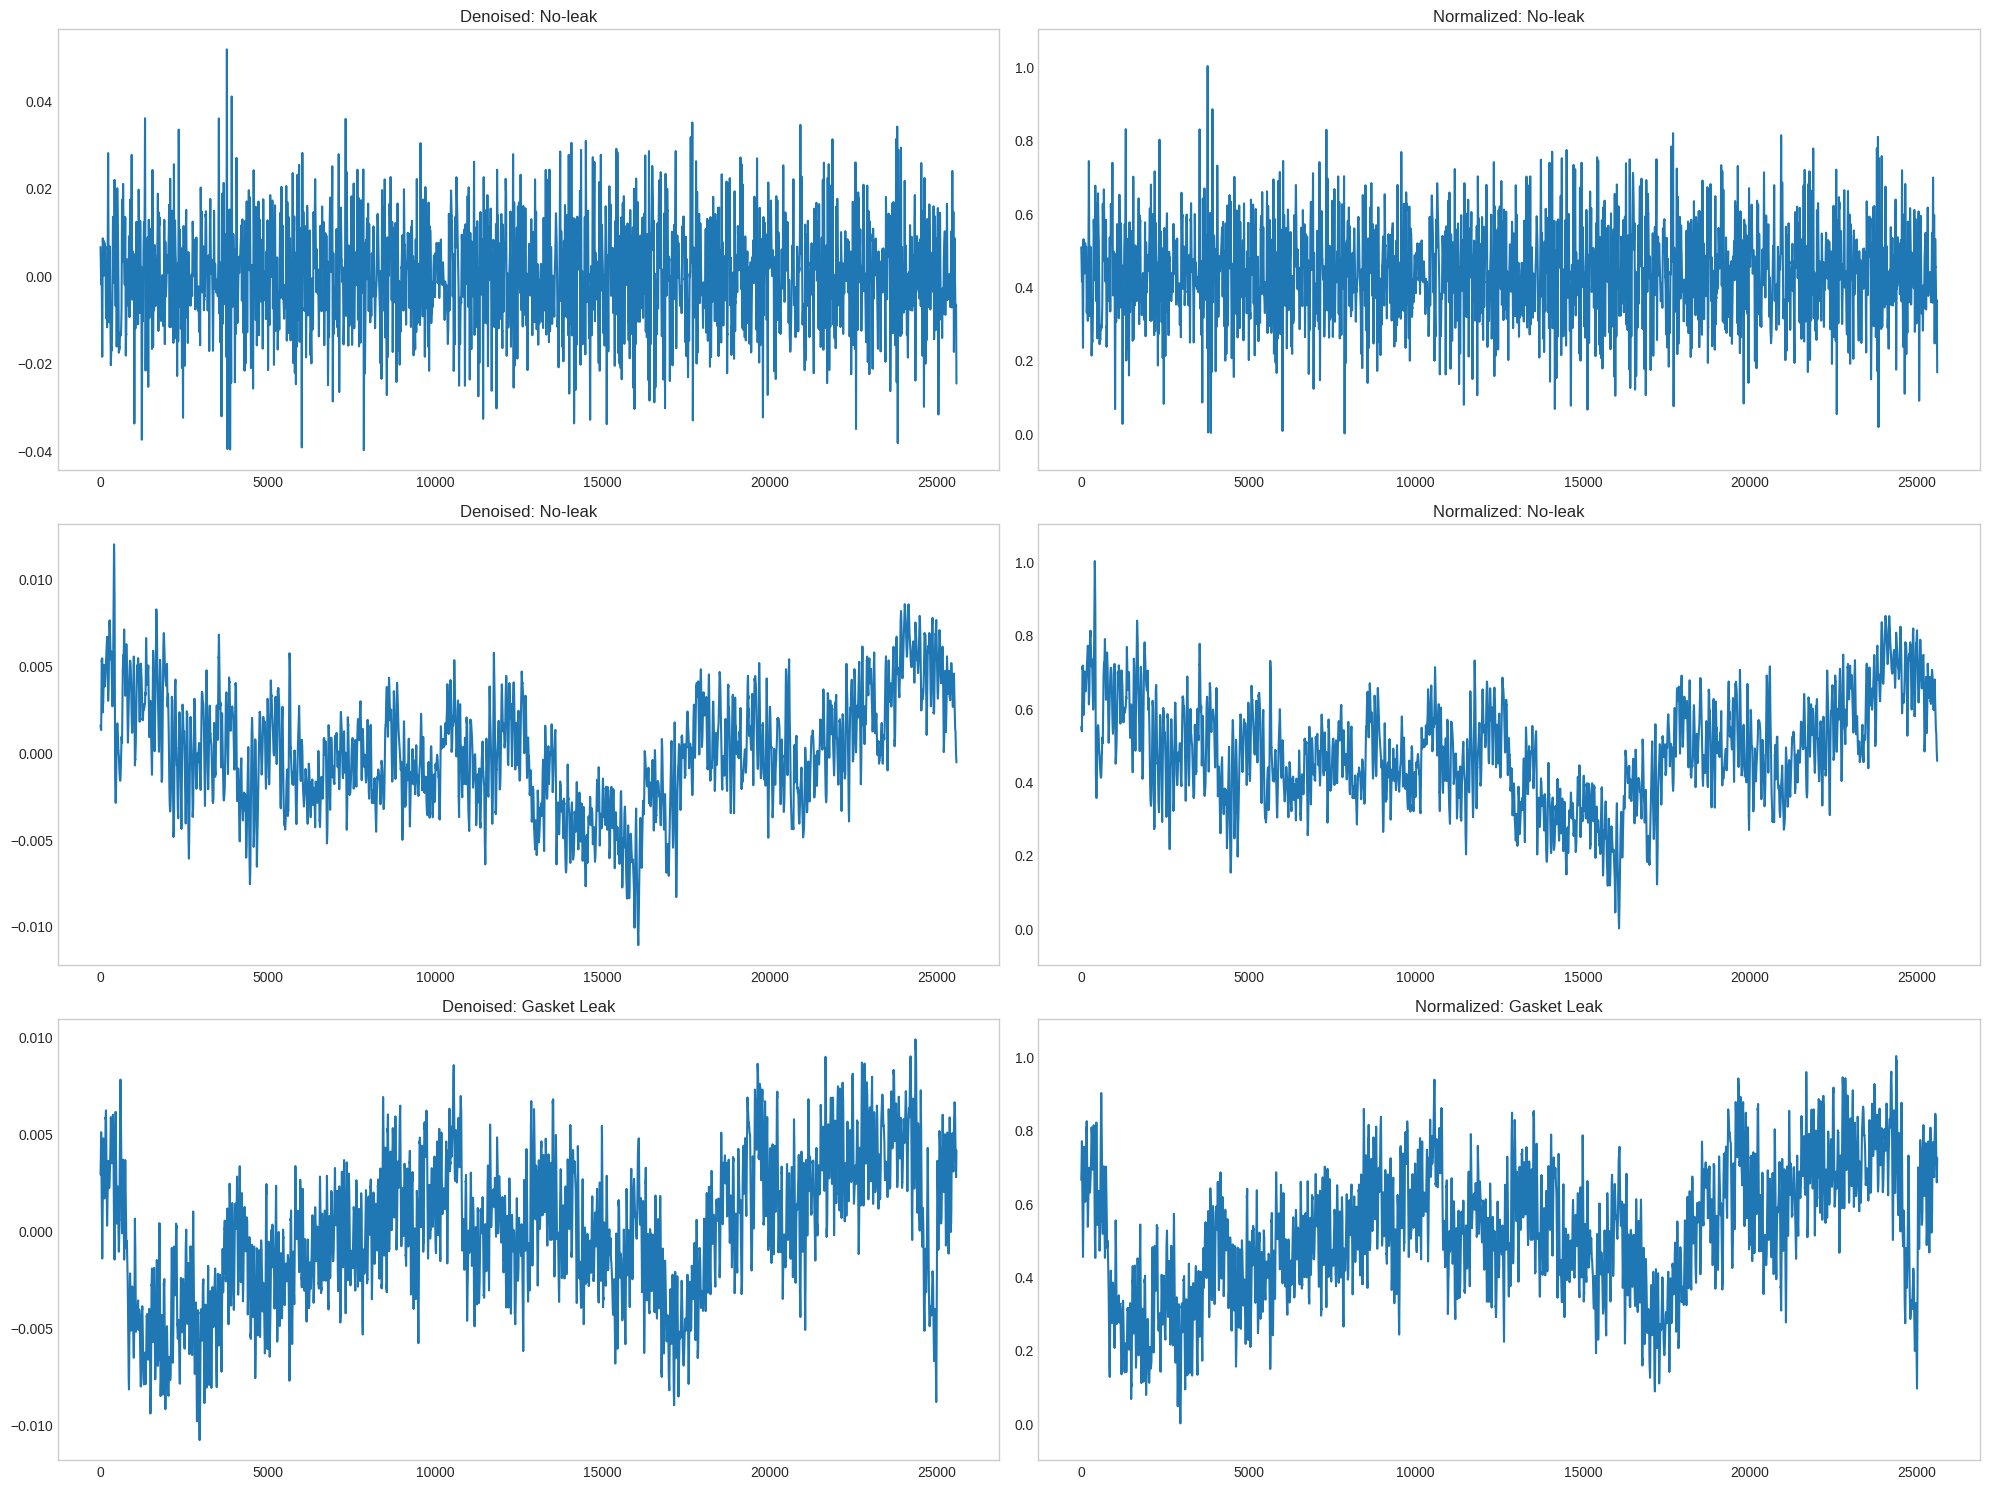

In [4]:
# Normalización de señales post-wavelet denoising

def normalize_signals(signals_dict):
    """
    Normaliza cada señal del diccionario a un rango de 0 a 1

    Args:
        signals_dict: Diccionario con señales a normalizar

    Returns:
        normalized_signals: Diccionario con señales normalizadas
    """
    # Crear un nuevo diccionario para almacenar las señales normalizadas:
    normalized_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal in tqdm(signals_subset, desc=f"Normalizando {key} signals"):
            # Encontrar el valor mínimo y máximo para cada señal
            min_val = np.min(signal)
            max_val = np.max(signal)

            # Evitar división por cero
            if max_val > min_val:
                # Normalizar la señal entre 0 y 1
                normalized_signal = (signal - min_val) / (max_val - min_val)
            else:
                # Si todos los valores son iguales, asignar 0.5 a todos
                normalized_signal = np.ones_like(signal) * 0.5

            # Almacenar la señal normalizada
            normalized_signals[key].append(normalized_signal)

    return normalized_signals

# Ejecutar la normalización en las señales con denoising
print("Normalizando señales procesadas con wavelet denoising...")
normalized_signals_dict = normalize_signals(wavelet_denoised_signals_dict)

# Imprimir información sobre el dataset normalizado:
print(f'Number of signals (training, testing): ({len(normalized_signals_dict["training"])}, {len(normalized_signals_dict["testing"])})')
print(f'Number of samples per signal: {len(normalized_signals_dict["training"][0])}')

# Comprobar rango de valores
for key in normalized_signals_dict:
    sample_signal = normalized_signals_dict[key][0]
    print(f"Rango de valores en {key}: [{np.min(sample_signal):.4f}, {np.max(sample_signal):.4f}]")

# Visualizar comparación de señales originales y normalizadas
plt.figure(figsize=(20, 15))
rows = 3
cols = 2
sample_indices = random_index[:3]  # Usar los mismos índices que antes

for i, idx in enumerate(sample_indices):
    # Señal con denoising (sin normalizar)
    plt.subplot(rows, cols, i*2+1)
    plt.plot(wavelet_denoised_signals_dict['training'][idx])

    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][idx])]
    else:
        label_name = 'Leak' if labels_dict['training'][idx] == 0 else 'No-leak'

    plt.title(f"Denoised: {label_name}")
    plt.grid()

    # Señal normalizada entre 0 y 1
    plt.subplot(rows, cols, i*2+2)
    plt.plot(normalized_signals_dict['training'][idx])
    plt.title(f"Normalized: {label_name}")
    plt.ylim([-0.1, 1.1])  # Ajustar límites para visualizar mejor la normalización
    plt.grid()

plt.tight_layout()
plt.show()

# Usar las señales normalizadas para los pasos siguientes
wavelet_denoised_signals_dict = normalized_signals_dict

## 4. Cálculo de Escalogramas con CWT

### 4.1 Función para calcular los escalogramas aplicando el CONE OF INFLUENCE

In [5]:
def calculate_cwt_with_coi(signal, fs=25600, f0=1.0, f1=None, fn=64,
                          sigma=6.0, fast=True, norm=True, scaling="log", nthreads=8):
    """
    Calcula la CWT de una señal utilizando la biblioteca fCWT con manejo del COI.
    """
    # Verificar tipo de datos y convertir si es necesario
    signal = np.array(signal, dtype=np.float32)

    # Establecer frecuencia máxima si no se especifica
    if f1 is None:
        f1 = fs/2

    # Inicializar la wavelet Morlet con el sigma especificado
    morlet = fcwt.Morlet(sigma)

    # Configurar escalas según el tipo de escalado
    if scaling.lower() == "log":
        scale_type = fcwt.FCWT_LOGSCALES
    else:
        scale_type = fcwt.FCWT_LINFREQS

    # Inicializar escalas como objeto
    scales_obj = fcwt.Scales(morlet, scale_type, fs, f0, f1, fn)

    # Extraer valores de escalas y frecuencias a arrays de NumPy
    # Crear arrays para almacenar los valores
    scales_array = np.zeros(fn, dtype=np.float32)
    freqs_array = np.zeros(fn, dtype=np.float32)

    # Llenar los arrays con los valores - estos métodos modifican los arrays pasados
    scales_obj.getScales(scales_array)
    scales_obj.getFrequencies(freqs_array)

    # Inicializar objeto FCWT
    fcwt_obj = fcwt.FCWT(morlet, nthreads, fast, norm)

    # Inicializar matriz de salida
    cwt_output = np.zeros((fn, len(signal)), dtype=np.complex64)

    # Calcular CWT - usar el objeto scales_obj directamente, no el array
    fcwt_obj.cwt(signal, scales_obj, cwt_output)

    # Calcular la máscara del COI usando el array de escalas (no el objeto)
    coi_mask = calculate_coi_mask(cwt_output, scales_array, len(signal), sigma)

    return freqs_array, cwt_output, coi_mask, scales_array


### 4.2 Función para calcular la máscara COI en la CWT

In [6]:
def calculate_coi_mask(cwt_output, scales, signal_length, sigma=6.0):
    """
    Calcula la máscara del Cone of Influence (COI) para un escalograma CWT.
    Ahora 'scales' es un array de NumPy, no un objeto SwigPyObject.
    """
    mask = np.ones_like(cwt_output, dtype=bool)

    # Calcular la máscara del COI para cada escala
    for i in range(len(scales)):
        scale = scales[i]  # Acceder a cada valor individualmente

        # El ancho del borde es proporcional a la escala y sigma
        border_width = int(np.ceil(sigma * np.sqrt(2) * scale))

        # Limitar el ancho del borde
        border_width = min(border_width, signal_length // 2)

        # Marcar regiones del COI como False
        if border_width > 0:
            mask[i, :border_width] = False
            mask[i, -border_width:] = False

    return mask

### 4.3 Función que te genera los escalogramas ya aplicando el COI

In [7]:
def get_cwt_features_with_coi(signals, labels, fs=25600, f0=1.0, f1=None, fn=64,
                           sigma=6.0, nthreads=8, scaling="log", fast=True, norm=True,
                           segment_size=512):
    """
    Calcula escalogramas CWT usando fCWT con aplicación de la máscara del COI.
    """
    # Configuración inicial
    if f1 is None:
        f1 = fs/2  # Frecuencia de Nyquist

    # Estructuras para almacenar resultados
    scalograms = []
    scalograms_with_coi = []  # Escalogramas sin aplicar máscara de COI
    segment_labels = []
    coi_percentages = []

    print(f"Calculando escalogramas con wavelet Morlet (sigma={sigma})")
    print(f"Rango de frecuencias: {f0} - {f1} Hz, {fn} bandas")

    # Procesar cada señal
    for i, (signal, label) in enumerate(tqdm(zip(signals, labels), total=len(signals), desc="Calculando CWT con COI")):
        # Dividir en segmentos
        num_segments = len(signal) // segment_size

        for j in range(num_segments):
            # Extraer segmento
            segment = signal[j*segment_size:(j+1)*segment_size]

            try:
                # Calcular CWT con manejo del COI
                freqs, cwt_coef, coi_mask, scales = calculate_cwt_with_coi(
                    segment, fs, f0, f1, fn, sigma, fast, norm, scaling, nthreads
                )

                # Calcular porcentaje de coeficientes dentro del COI válido
                valid_percentage = np.mean(coi_mask) * 100
                coi_percentages.append(valid_percentage)

                # Crear escalograma completo (sin aplicar máscara)
                scalogram_full = np.square(np.abs(cwt_coef)).T

                # Crear escalograma con COI aplicado (NaN en los bordes afectados)
                scalogram_coi = scalogram_full.copy()
                scalogram_coi[coi_mask.T] = 0

                # Normalizar escalogramas
              #  max_val_full = np.nanmax(scalogram_full)
              #  if max_val_full > 0:
              #      scalogram_full = scalogram_full / max_val_full
              #      scalogram_coi = scalogram_coi / max_val_full

                # Para entrenamiento, reemplazar NaN con ceros
                training_scalogram = np.nan_to_num(scalogram_coi, nan=0.0)

                # Almacenar resultados
                scalograms.append(training_scalogram)
                scalograms_with_coi.append(scalogram_full)
                segment_labels.append(label)

            except Exception as e:
                print(f"Error en segmento {j} de señal {i}: {e}")
                continue

    # Mostrar información sobre los escalogramas generados
    if len(coi_percentages) > 0:
        avg_valid = np.mean(coi_percentages)
        print(f"Escalogramas calculados: {len(scalograms)}")
        print(f"Porcentaje promedio de datos válidos (fuera del COI): {avg_valid:.2f}%")
        if len(scalograms) > 0:
            print(f"Forma de un escalograma: {scalograms[0].shape}")

    return scalograms, segment_labels, coi_percentages, scalograms_with_coi

### 4.4 Función para visualizar los escalogramas y ver la diferencia entre el uso del COI  y el escalograma general

In [8]:
# Función para visualizar los escalogramas COI vs original
def plot_cwt_scalograms_comparison(scalograms_original, scalograms_coi, labels,
                                  label_codes_dict, num_per_class=2,
                                  fs=25600, segment_size=512, sigma=6.0):
    """
    Visualiza una comparación entre escalogramas originales y con COI aplicado.
    """
    # Configuración de visualización
    t_duration = segment_size / fs
    f0 = 1.0
    f1 = fs/2

    # Configurar subplot grid
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    rows = num_classes
    cols = 2 * num_per_class

    plt.figure(figsize=(15, 4*rows))

    for i, label_code in enumerate(unique_labels):
        # Obtener índices de esta clase
        class_indices = [idx for idx, l in enumerate(labels) if l == label_code]

        if len(class_indices) == 0:
            continue

        # Seleccionar ejemplos aleatorios
        selected_indices = random.sample(class_indices, min(num_per_class, len(class_indices)))

        for j, idx in enumerate(selected_indices):
            # Obtener etiqueta en texto
            if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = 'Leak' if label_code == 0 else 'No-leak'

            # Escalograma original
            ax = plt.subplot(rows, cols, i*cols + j*2 + 1)
            im = ax.imshow(scalograms_original[idx], aspect='auto', origin='lower',
                         extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"Original: {label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

            # Escalograma con COI aplicado
            ax = plt.subplot(rows, cols, i*cols + j*2 + 2)
            im = ax.imshow(scalograms_coi[idx], aspect='auto', origin='lower',
                         extent=[0, t_duration, f0, f1], cmap=cm.viridis)
            ax.set_yscale('log')
            ax.set_title(f"COI aplicado: {label_name} (σ={sigma})")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')
            plt.colorbar(im, ax=ax, label='Energía')

    plt.tight_layout()
    plt.show()

### 5.1 Funcion para salvar los datasets

In [9]:
# Función para guardar datasets procesados
def save_cwt_dataset(file_path, x_train, y_train, x_test, y_test, classification_mode, label_codes_dict=None):
    """
    Guarda el dataset de escalogramas procesados en formato HDF5
    """
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Determinar número de clases
    num_classes = 5 if classification_mode == 'five_classes' else 2

    # Dividir conjunto de entrenamiento para crear un conjunto de validación
    val_split = 0.2
    val_indices = np.random.choice(len(x_train), int(len(x_train) * val_split), replace=False)
    train_mask = np.ones(len(x_train), dtype=bool)
    train_mask[val_indices] = False

    x_val = x_train[~train_mask]
    y_val = y_train[~train_mask]
    x_train = x_train[train_mask]
    y_train = y_train[train_mask]

    # Convertir etiquetas a one-hot
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

    # Guardar en formato HDF5
    with h5py.File(file_path, 'w') as hf:
        # Crear grupos
        train_group = hf.create_group('train')
        val_group = hf.create_group('val')
        test_group = hf.create_group('test')
        metadata_group = hf.create_group('metadata')
        shapes_group = hf.create_group('shapes')

        # Guardar conjuntos de datos
        train_group.create_dataset('x_train', data=x_train)
        train_group.create_dataset('y_train', data=y_train)
        train_group.create_dataset('y_train_onehot', data=y_train_onehot)

        val_group.create_dataset('x_val', data=x_val)
        val_group.create_dataset('y_val', data=y_val)
        val_group.create_dataset('y_val_onehot', data=y_val_onehot)

        test_group.create_dataset('x_test', data=x_test)
        test_group.create_dataset('y_test', data=y_test)
        test_group.create_dataset('y_test_onehot', data=y_test_onehot)

        # Guardar metadatos
        metadata_group.attrs['num_classes'] = num_classes
        metadata_group.attrs['classification_mode'] = classification_mode

        # Guardar formas
        shapes_group.attrs['x_train_shape'] = x_train.shape
        shapes_group.attrs['x_val_shape'] = x_val.shape
        shapes_group.attrs['x_test_shape'] = x_test.shape

    # Si hay un diccionario de códigos de etiquetas, guardarlo en un archivo de texto
    if label_codes_dict is not None:
        classes_file = file_path.replace('.h5', '_classes.txt')
        with open(classes_file, 'w') as f:
            for name, code in label_codes_dict.items():
                f.write(f"{name}: {code}\n")

    print(f"Dataset guardado en: {file_path}")
    print(f"Información del dataset guardado:")
    print(f"- Modo de clasificación: {classification_mode}")
    print(f"- Número de clases: {num_classes}")
    print(f"- Muestras de entrenamiento: {len(x_train)}")
    print(f"- Muestras de validación: {len(x_val)}")
    print(f"- Muestras de prueba: {len(x_test)}")
    print(f"- Forma de los datos: {x_train.shape}")

    return {
        'x_train': x_train,
        'y_train': y_train,
        'y_train_onehot': y_train_onehot,
        'x_val': x_val,
        'y_val': y_val,
        'y_val_onehot': y_val_onehot,
        'x_test': x_test,
        'y_test': y_test,
        'y_test_onehot': y_test_onehot
    }

### 5.2 Función para preparar los datos para que sean entrada de una CNN

In [10]:
# Función para preparar datos para CNN
def prepare_data_for_cnn(scalograms, labels, input_shape=None):
    """Prepara los escalogramas para CNN añadiendo canal de color y redimensionando si es necesario."""
    X = np.array(scalograms)
    y = np.array(labels)

    # Añadir canal de color (escala de grises = 1 canal)
    if len(X.shape) == 3:
        X = X.reshape(X.shape + (1,))


    return X, y

## 6.Obtención de escalogramas con diferentes sigmas

In [11]:

# Definimos los valores de sigma a evaluar
sigma_values = [6.0]
results = {}
# Calcular escalogramas para cada valor de sigma
for sigma in sigma_values:
    print(f"\n=== Calculando escalogramas con sigma = {sigma} ===")

    # Calcular escalogramas con manejo del COI
    train_scalograms, train_labels, train_coi_percentages, train_scalograms_full = get_cwt_features_with_coi(
        wavelet_denoised_signals_dict['training'],
        labels_dict['training'],
        segment_size=512,
        fn=10,
        sigma=sigma,
        scaling="log",
        nthreads=1
    )

    test_scalograms, test_labels, test_coi_percentages, test_scalograms_full = get_cwt_features_with_coi(
        wavelet_denoised_signals_dict['testing'],
        labels_dict['testing'],
        segment_size=512,
        fn=10,
        sigma=sigma,
        scaling="log",
        nthreads=1
    )

    # Mostrar información
    print(f"Escalogramas de entrenamiento: {len(train_scalograms)}")
    print(f"Escalogramas de prueba: {len(test_scalograms)}")

    if len(train_scalograms) > 0:
        print(f"Forma de un escalograma: {train_scalograms[0].shape}")

    # Guardar resultados para este sigma
    results[sigma] = {
        'train_scalograms': train_scalograms,
        'train_labels': train_labels,
        'test_scalograms': test_scalograms,
        'test_labels': test_labels,
        'train_scalograms_full': train_scalograms_full,
        'test_scalograms_full': test_scalograms_full
    }

    # Guardar los escalogramas en formato npz para evitar cálculos repetidos
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    np.savez_compressed(
        f'coi_scalograms_sigma_{sigma}_{timestamp}.npz',
        train_scalograms=train_scalograms,
        train_labels=train_labels,
        test_scalograms=test_scalograms,
        test_labels=test_labels,
        train_scalograms_full=train_scalograms_full,
        test_scalograms_full=test_scalograms_full,
        sigma=sigma
    )
    print(f"Escalogramas con sigma={sigma} guardados con éxito.")

print("\nProcesamiento de escalogramas completado para todos los valores de sigma.")


=== Calculando escalogramas con sigma = 6.0 ===
Calculando escalogramas con wavelet Morlet (sigma=6.0)
Rango de frecuencias: 1.0 - 12800.0 Hz, 10 bandas


Calculando CWT con COI: 100%|██████████| 960/960 [00:53<00:00, 17.81it/s]


Escalogramas calculados: 48000
Porcentaje promedio de datos válidos (fuera del COI): 21.99%
Forma de un escalograma: (512, 10)
Calculando escalogramas con wavelet Morlet (sigma=6.0)
Rango de frecuencias: 1.0 - 12800.0 Hz, 10 bandas


Calculando CWT con COI: 100%|██████████| 240/240 [00:07<00:00, 33.34it/s]


Escalogramas calculados: 12000
Porcentaje promedio de datos válidos (fuera del COI): 21.99%
Forma de un escalograma: (512, 10)
Escalogramas de entrenamiento: 48000
Escalogramas de prueba: 12000
Forma de un escalograma: (512, 10)
Escalogramas con sigma=6.0 guardados con éxito.

Procesamiento de escalogramas completado para todos los valores de sigma.


## 7.Visualización de escalogramas con/sin COI


=== Visualizando escalogramas con sigma = 6.0 ===


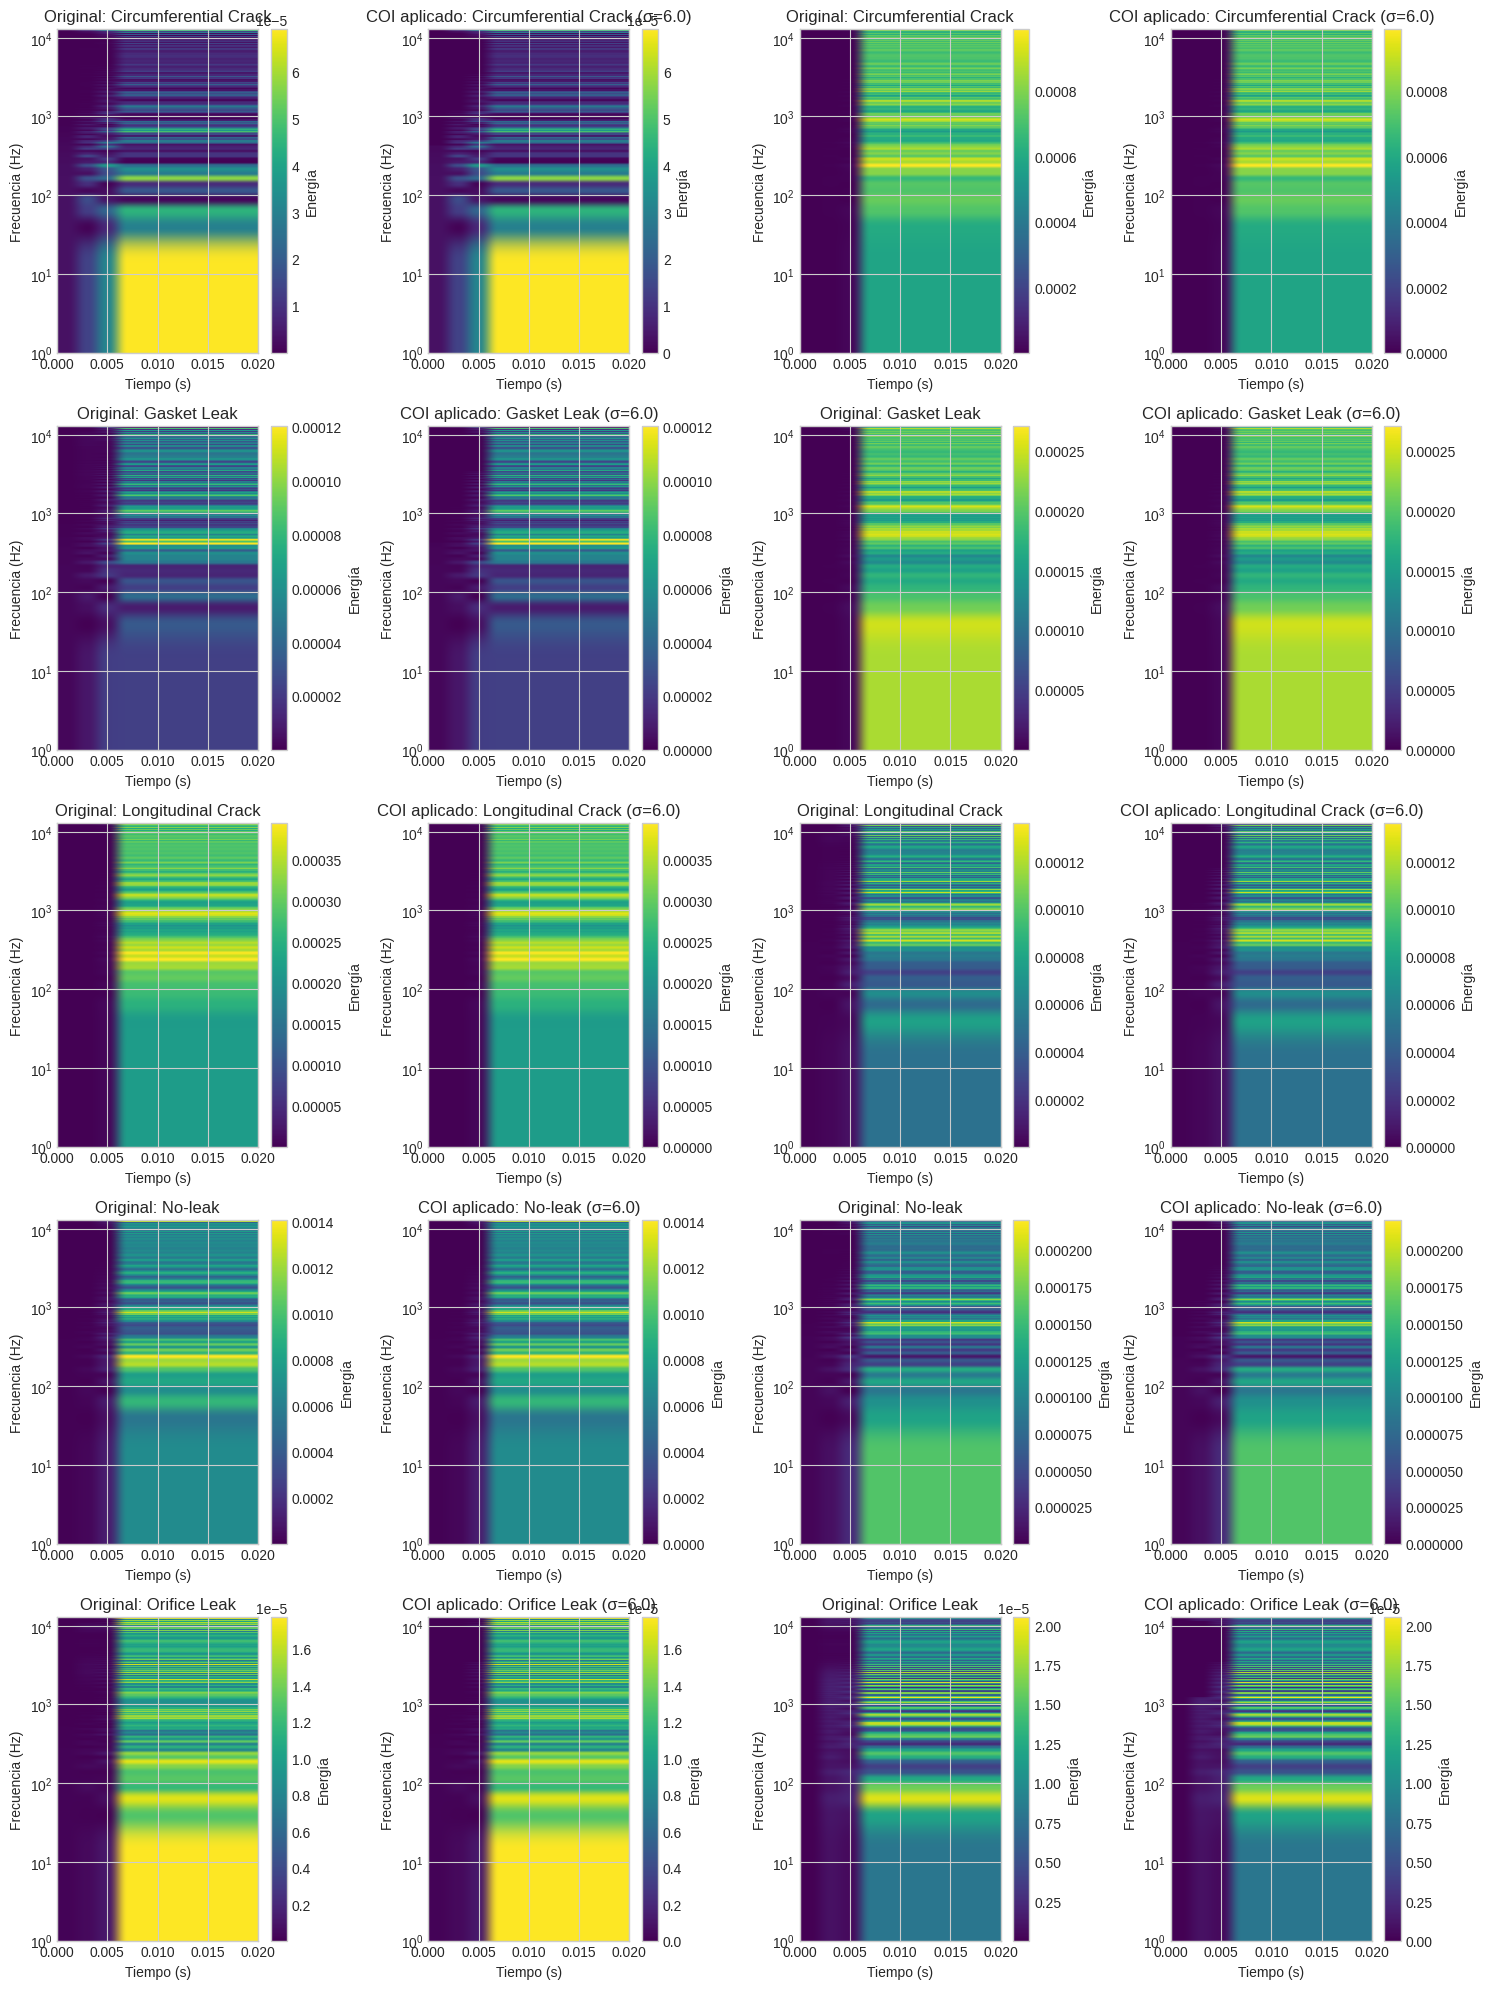

In [12]:
# Visualizar escalogramas para cada sigma
for sigma in sigma_values:
    print(f"\n=== Visualizando escalogramas con sigma = {sigma} ===")

    # Obtener los escalogramas para este sigma
    train_scalograms_full = results[sigma]['train_scalograms_full']
    train_scalograms = results[sigma]['train_scalograms']
    train_labels = results[sigma]['train_labels']

    # Visualizar comparación entre original y con COI
    plot_cwt_scalograms_comparison(
        train_scalograms_full,
        train_scalograms,
        train_labels,
        label_codes_dict,
        num_per_class=2,
        sigma=sigma
    )

## 7.1 Mejora de Contraste con Filtro Gaussiano 2D


=== Mejorando escalogramas con filtro Gaussiano (sigma=6.0) ===

Probando diferentes valores del kernel gaussiano:


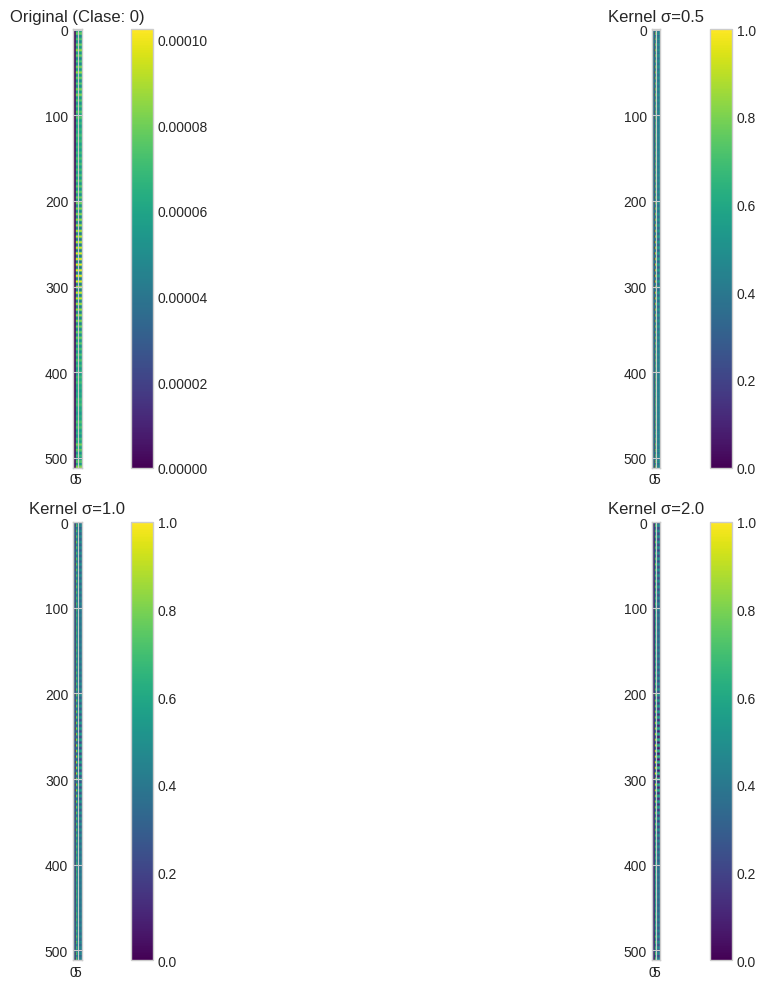

Utilizando kernel gaussian con σ=1.0 para todos los escalogramas


Aplicando filtro Gaussiano: 100%|██████████| 12000/12000 [00:02<00:00, 5920.93it/s]


Escalogramas de entrenamiento mejorados: 48000
Escalogramas de prueba mejorados: 12000

Visualizando comparación de escalogramas por clase:


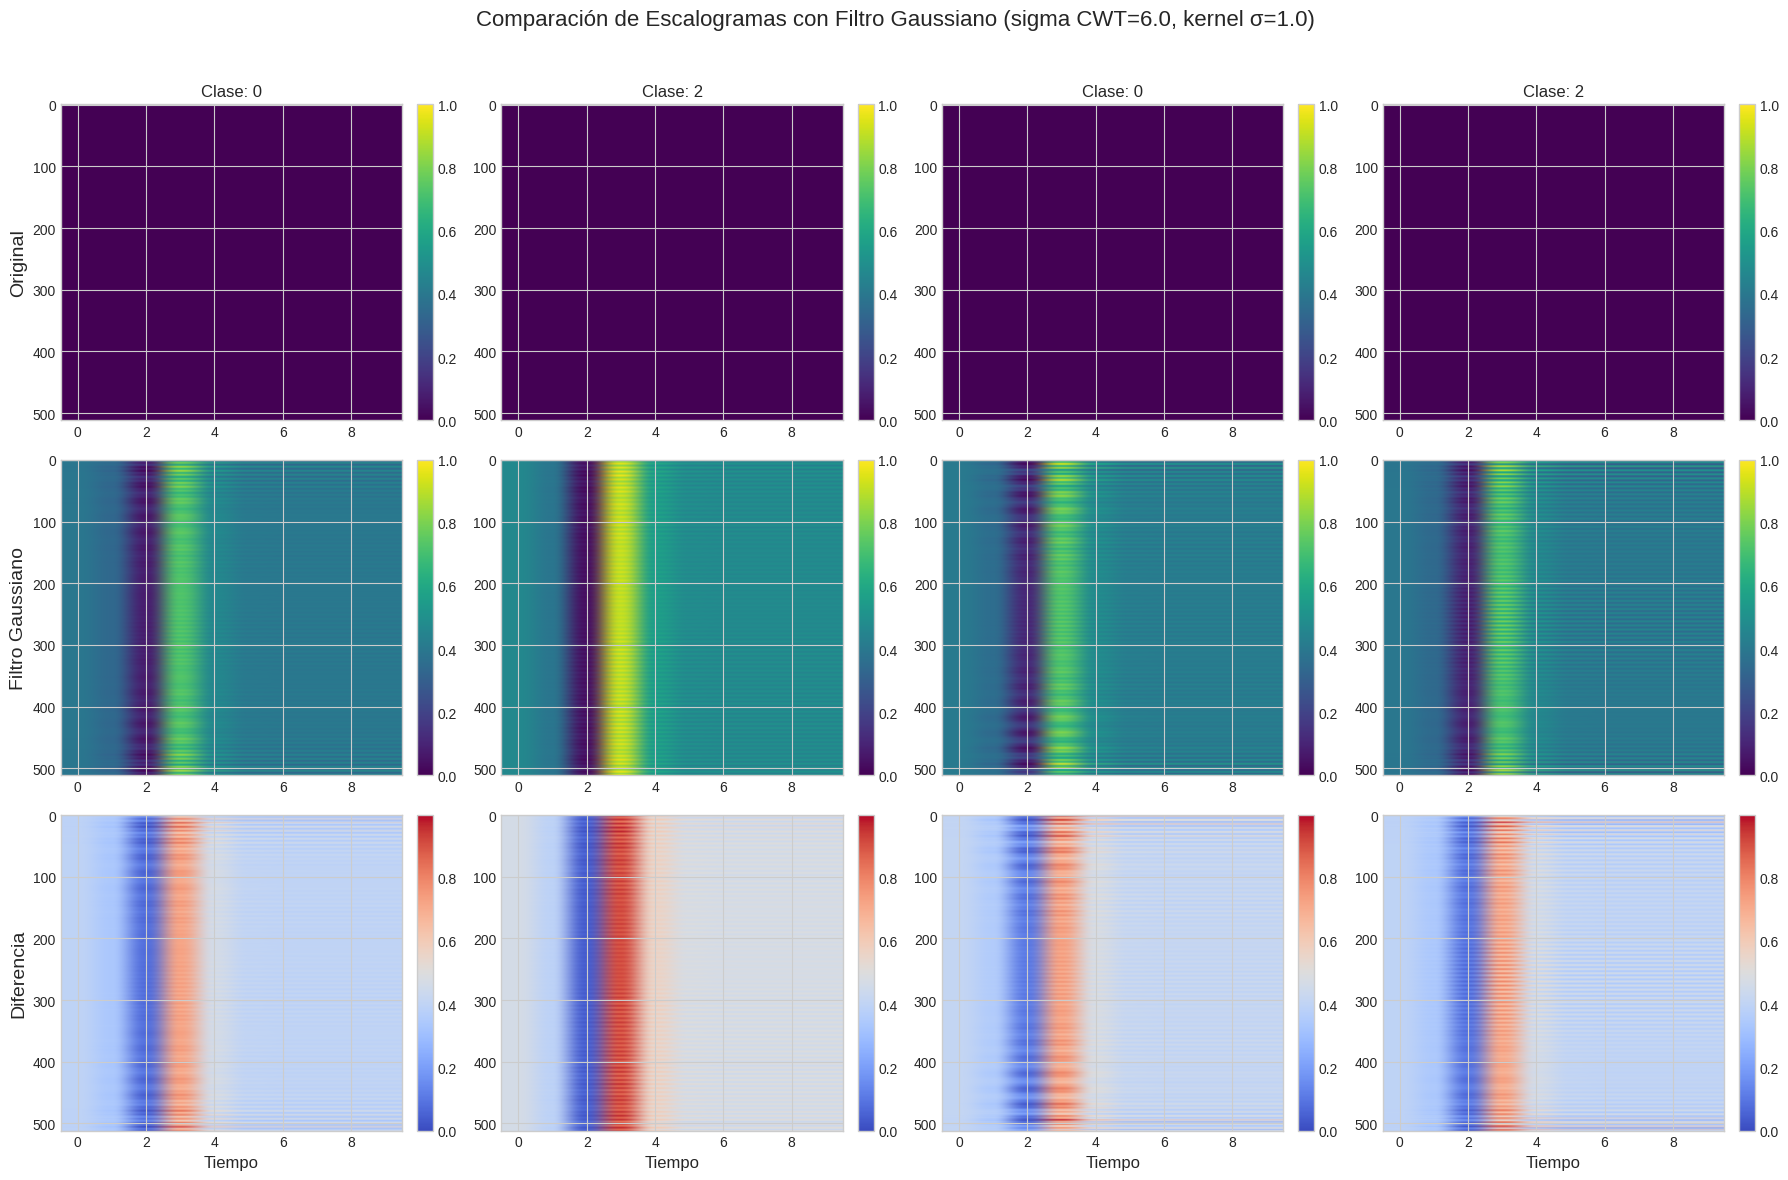

Figura guardada en /content/drive/MyDrive/Tesis/Results/gaussian_filter_comparison_sigma6.0_20250328_030938.png

Análisis del efecto del filtro gaussiano:
Media original: 0.0002 → Media mejorada: 0.3812
Desviación estándar original: 0.0001 → Desviación estándar mejorada: 0.1140
Mejora en contraste: 189586.25%


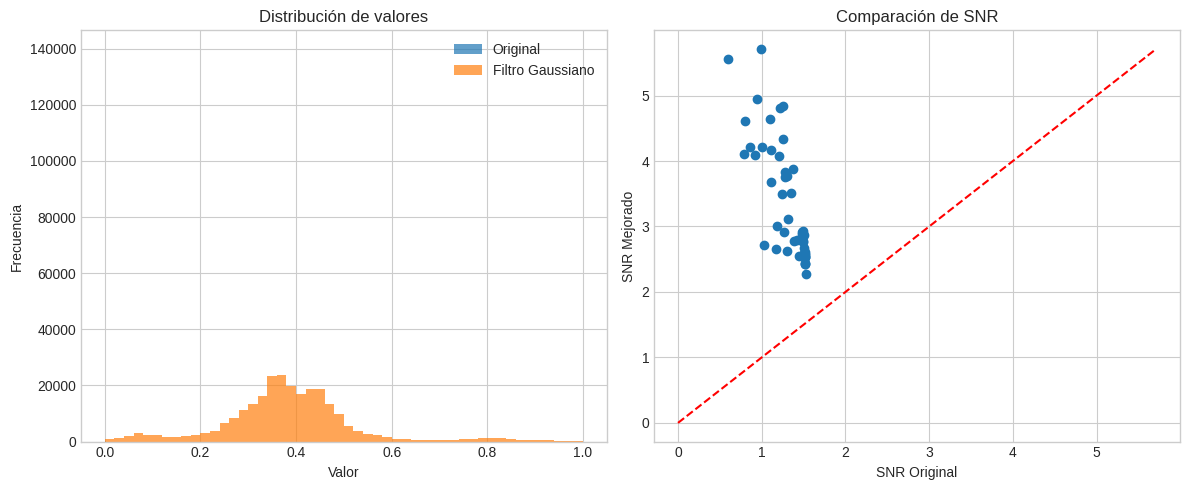


Procesamiento de escalogramas con filtro Gaussiano completado.


In [13]:
# 7.1 Mejora de Contraste con Filtro Gaussiano 2D

from scipy.ndimage import gaussian_filter

def plot_cwt_scalograms_comparison(original_scalograms, enhanced_scalograms, labels=None,
                                 num_examples=3, figsize=(18, 12), title=None):
    """
    Visualiza la comparación entre escalogramas originales y mejorados con filtro gaussiano.

    Args:
        original_scalograms: Lista de escalogramas originales
        enhanced_scalograms: Lista de escalogramas mejorados con filtro
        labels: Etiquetas de clase para cada escalograma
        num_examples: Número de ejemplos a mostrar
        figsize: Tamaño de la figura
        title: Título principal
    """
    # Seleccionar escalogramas aleatoriamente pero que incluyan diferentes clases si es posible
    unique_indices = []

    if labels is not None:
        # Intentar obtener ejemplos de diferentes clases
        unique_classes = np.unique(labels)
        for cls in unique_classes:
            indices = np.where(labels == cls)[0]
            if len(indices) > 0:
                unique_indices.append(np.random.choice(indices))
                if len(unique_indices) >= num_examples:
                    break

    # Si no hay suficientes clases o no se proporcionaron etiquetas
    while len(unique_indices) < min(num_examples, len(original_scalograms)):
        idx = np.random.randint(0, len(original_scalograms))
        if idx not in unique_indices:
            unique_indices.append(idx)

    # Crear figura
    fig = plt.figure(figsize=figsize)

    if title:
        plt.suptitle(title, fontsize=16, y=0.98)

    # Crear cuadrícula de subplots: 3 filas (original, mejorado, diferencia) x num_examples columnas
    for i, idx in enumerate(unique_indices):
        # Obtener escalogramas
        orig_scal = original_scalograms[idx]
        enhanced_scal = enhanced_scalograms[idx]
        diff = enhanced_scal - orig_scal  # Diferencia para ver qué cambió

        # Calcular min/max globales para colorbar consistente
        vmin = min(np.min(orig_scal), np.min(enhanced_scal))
        vmax = max(np.max(orig_scal), np.max(enhanced_scal))

        # Escalograma original
        ax1 = plt.subplot(3, num_examples, i + 1)
        im1 = ax1.imshow(orig_scal, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        if i == 0:
            ax1.set_ylabel('Original', fontsize=14)

        if labels is not None:
            label_text = f"Clase: {labels[idx]}"
            ax1.set_title(label_text)
        else:
            ax1.set_title(f"Ejemplo {i+1}")

        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

        # Escalograma mejorado con filtro
        ax2 = plt.subplot(3, num_examples, i + 1 + num_examples)
        im2 = ax2.imshow(enhanced_scal, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        if i == 0:
            ax2.set_ylabel('Filtro Gaussiano', fontsize=14)
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

        # Diferencia entre original y mejorado
        ax3 = plt.subplot(3, num_examples, i + 1 + 2*num_examples)
        # Usar divergente para ver aumentos/disminuciones
        im3 = ax3.imshow(diff, cmap='coolwarm', aspect='auto')
        if i == 0:
            ax3.set_ylabel('Diferencia', fontsize=14)
        ax3.set_xlabel('Tiempo', fontsize=12)
        plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

def apply_gaussian_filter(scalograms, sigma=1.0, return_params=False):
    """
    Aplica un filtro gaussiano 2D a los escalogramas para mejorar el contraste
    como se describe en el paper.

    Args:
        scalograms: Lista o array de escalogramas
        sigma: Desviación estándar del kernel gaussiano
        return_params: Si True, devuelve también parámetros de normalización

    Returns:
        Lista de escalogramas con filtro gaussiano aplicado
    """
    enhanced_scalograms = []
    params = []  # Para guardar parámetros de normalización

    for i, scalogram in enumerate(tqdm(scalograms, desc="Aplicando filtro Gaussiano")):
        # Aplicar filtro gaussiano para suavizar
        filtered = gaussian_filter(scalogram, sigma=sigma)

        # Aumentar el contraste: restar el filtrado del original
        enhanced = scalogram - filtered

        # Normalizar resultado entre 0 y 1
        min_val = np.min(enhanced)
        max_val = np.max(enhanced)
        if max_val > min_val:
            enhanced = (enhanced - min_val) / (max_val - min_val)

        enhanced_scalograms.append(enhanced)

        if return_params:
            params.append({
                'min': min_val,
                'max': max_val
            })

    if return_params:
        return np.array(enhanced_scalograms), params
    return np.array(enhanced_scalograms)

# Aplicar filtro gaussiano a los escalogramas de entrenamiento y prueba para cada sigma
enhanced_results = {}

for sigma in sigma_values:
    print(f"\n=== Mejorando escalogramas con filtro Gaussiano (sigma={sigma}) ===")

    # Obtener escalogramas originales
    train_scalograms = results[sigma]['train_scalograms']
    test_scalograms = results[sigma]['test_scalograms']
    train_labels = results[sigma]['train_labels']
    test_labels = results[sigma]['test_labels']

    # Aplicar filtro gaussiano para mejorar contraste con diferentes valores del kernel
    print("\nProbando diferentes valores del kernel gaussiano:")
    kernel_values = [0.5, 1.0, 2.0]

    plt.figure(figsize=(16, 10))

    # Visualizar un escalograma de ejemplo con diferentes valores de kernel
    example_idx = np.random.randint(0, len(train_scalograms))
    example_scalogram = train_scalograms[example_idx]

    # Subplot para original
    plt.subplot(2, 2, 1)
    plt.imshow(example_scalogram, cmap='viridis')
    plt.title(f"Original (Clase: {train_labels[example_idx]})")
    plt.colorbar()

    # Subplots para diferentes valores de kernel
    for i, kernel_sigma in enumerate(kernel_values):
        enhanced = example_scalogram - gaussian_filter(example_scalogram, sigma=kernel_sigma)
        min_val = np.min(enhanced)
        max_val = np.max(enhanced)
        if max_val > min_val:
            enhanced = (enhanced - min_val) / (max_val - min_val)

        plt.subplot(2, 2, i+2)
        plt.imshow(enhanced, cmap='viridis')
        plt.title(f"Kernel σ={kernel_sigma}")
        plt.colorbar()

    plt.tight_layout()
    plt.show()

    # Seleccionar kernel_sigma basado en los resultados visuales (usamos 1.0 por defecto)
    selected_kernel = 1.0
    print(f"Utilizando kernel gaussian con σ={selected_kernel} para todos los escalogramas")

    # Aplicar filtro gaussiano a todos los escalogramas
    enhanced_train_scalograms = apply_gaussian_filter(train_scalograms, sigma=selected_kernel)
    enhanced_test_scalograms = apply_gaussian_filter(test_scalograms, sigma=selected_kernel)

    # Guardar resultados mejorados
    enhanced_results[sigma] = {
        'train_scalograms': enhanced_train_scalograms,
        'train_labels': train_labels,
        'test_scalograms': enhanced_test_scalograms,
        'test_labels': test_labels
    }

    # Mostrar información
    print(f"Escalogramas de entrenamiento mejorados: {len(enhanced_train_scalograms)}")
    print(f"Escalogramas de prueba mejorados: {len(enhanced_test_scalograms)}")

    # Visualizar comparativa de escalogramas para cada clase
    print("\nVisualizando comparación de escalogramas por clase:")

    # Visualización detallada para entrenamiento
    title = f"Comparación de Escalogramas con Filtro Gaussiano (sigma CWT={sigma}, kernel σ={selected_kernel})"
    fig_train = plot_cwt_scalograms_comparison(
        train_scalograms[:100],  # Limitamos a 100 para eficiencia
        enhanced_train_scalograms[:100],
        train_labels[:100],
        num_examples=4,
        title=title
    )
    plt.show()

    # Guardar figura si estamos en Colab
    os.makedirs('/content/drive/MyDrive/Tesis/Results', exist_ok=True)

    if 'google.colab' in sys.modules:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        fig_path = f'/content/drive/MyDrive/Tesis/Results/gaussian_filter_comparison_sigma{sigma}_{timestamp}.png'
        fig_train.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Figura guardada en {fig_path}")

    # Analizar el efecto del filtro gaussiano
    print("\nAnálisis del efecto del filtro gaussiano:")

    # Calcular estadísticas
    orig_mean = np.mean([np.mean(scal) for scal in train_scalograms])
    enhanced_mean = np.mean([np.mean(scal) for scal in enhanced_train_scalograms])

    orig_std = np.mean([np.std(scal) for scal in train_scalograms])
    enhanced_std = np.mean([np.std(scal) for scal in enhanced_train_scalograms])

    # Calcular mejora de contraste promedio
    contrast_orig = np.mean([np.max(scal) - np.min(scal) for scal in train_scalograms])
    contrast_enhanced = np.mean([np.max(scal) - np.min(scal) for scal in enhanced_train_scalograms])
    contrast_improvement = (contrast_enhanced / contrast_orig) * 100 - 100

    print(f"Media original: {orig_mean:.4f} → Media mejorada: {enhanced_mean:.4f}")
    print(f"Desviación estándar original: {orig_std:.4f} → Desviación estándar mejorada: {enhanced_std:.4f}")
    print(f"Mejora en contraste: {contrast_improvement:.2f}%")

    # Visualizar la distribución de valores antes y después del filtrado
    plt.figure(figsize=(12, 5))

    # Tomar una muestra de escalogramas para el histograma
    sample_size = min(len(train_scalograms), 50)
    sample_indices = np.random.choice(len(train_scalograms), sample_size, replace=False)

    orig_values = np.concatenate([train_scalograms[i].flatten() for i in sample_indices])
    enhanced_values = np.concatenate([enhanced_train_scalograms[i].flatten() for i in sample_indices])

    plt.subplot(1, 2, 1)
    plt.hist(orig_values, bins=50, alpha=0.7, label='Original')
    plt.hist(enhanced_values, bins=50, alpha=0.7, label='Filtro Gaussiano')
    plt.title('Distribución de valores')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.legend()

    # Comparar SNR (Signal-to-Noise Ratio) aproximado
    plt.subplot(1, 2, 2)
    snr_orig = np.array([np.mean(scal) / np.std(scal) for scal in [train_scalograms[i] for i in sample_indices]])
    snr_enhanced = np.array([np.mean(scal) / np.std(scal) for scal in [enhanced_train_scalograms[i] for i in sample_indices]])

    plt.scatter(snr_orig, snr_enhanced)
    plt.plot([0, max(np.max(snr_orig), np.max(snr_enhanced))],
             [0, max(np.max(snr_orig), np.max(snr_enhanced))], 'r--')
    plt.xlabel('SNR Original')
    plt.ylabel('SNR Mejorado')
    plt.title('Comparación de SNR')

    plt.tight_layout()
    plt.show()

print("\nProcesamiento de escalogramas con filtro Gaussiano completado.")

## 9.Entrenamiento del Modelo Híbrido CNN-LSTM con Selección Genética

In [14]:
!pip install deap

In [ ]:
# 9. Entrenamiento del Modelo Híbrido CNN-LSTM con Selección Genética (Optimizado para memoria)

# Importaciones necesarias para el modelo optimizado
import gc
import os
import sys
import time
import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, BatchNormalization, Reshape, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from deap import base, creator, tools, algorithms
import random
from tqdm.notebook import tqdm




# Definir prepare_data_for_cnn si no está ya definida
if 'prepare_data_for_cnn' not in globals():
    def prepare_data_for_cnn(scalograms, labels):
        """
        Prepara los escalogramas para CNN añadiendo el canal de color.
        """
        X = np.array(scalograms)
        y = np.array(labels)

        # Añadir canal de color (escala de grises = 1 canal)
        if len(X.shape) == 3:
            X = X.reshape(X.shape + (1,))

        print(f"Forma de escalogramas preparados: {X.shape}")

        return X, y

# Función para liberar memoria
def clear_memory():
    """Libera memoria no utilizada"""
    import gc
    gc.collect()
    if 'tensorflow' in sys.modules:
        import tensorflow as tf
        tf.keras.backend.clear_session()




# Función para construir modelo clasificador completo para pre-entrenamiento
def build_pretraining_model(input_shape, num_classes=5, dropout_rate=0.5, l2_reg=0.001):
    """
    Construye un modelo completo CNN+LSTM para pre-entrenamiento.
    Después del entrenamiento, se puede quitar la capa final para obtener el extractor.
    """
    # Regularizador L2
    reg = l2(l2_reg)

    # Entrada del modelo
    inputs = Input(shape=input_shape)

    # Extraer dimensiones para planificar la arquitectura
    input_height = input_shape[0]
    input_width = input_shape[1]
    print(f"Dimensiones de entrada: {input_height}x{input_width}")

    # Bloque 1: Primera convolución
    x = Conv2D(16, (3, 3), padding='same', kernel_regularizer=reg, name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Solo aplicar MaxPooling si las dimensiones lo permiten
    if input_height >= 2 and input_width >= 2:
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
        current_height = input_height // 2
        current_width = input_width // 2
    else:
        current_height = input_height
        current_width = input_width
        print("Saltando primer MaxPooling - dimensiones demasiado pequeñas")

    # Bloque 2: Segunda convolución
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg, name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Solo aplicar MaxPooling si las dimensiones lo permiten
    if current_height >= 2 and current_width >= 2:
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
        current_height //= 2
        current_width //= 2
    else:
        print("Saltando segundo MaxPooling - dimensiones demasiado pequeñas")

    # Bloque 3: Tercera convolución
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=reg, name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Solo aplicar MaxPooling si las dimensiones lo permiten
    if current_height >= 2 and current_width >= 2:
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
        current_height //= 2
        current_width //= 2
    else:
        print("Saltando tercer MaxPooling - dimensiones demasiado pequeñas")

    # En lugar de additional_pool, usar Global Average Pooling directamente
    spatial_features = GlobalAveragePooling2D()(x)

    # Resto del modelo sin cambios
    spatial_features = Dense(128, activation='relu', kernel_regularizer=reg, name='dense_features_128')(spatial_features)

    # Reshape para LSTM: crear una secuencia artificial más pequeña
    reshaped = Reshape((8, 16))(spatial_features)  # 8 pasos temporales, 16 características

    # Capa LSTM
    lstm_out = LSTM(32, return_sequences=False,
                   kernel_regularizer=reg,
                   recurrent_regularizer=reg,
                   activation='tanh',
                   name='lstm_features')(reshaped)

    # Dropout para regularización
    x = Dropout(dropout_rate, name='dropout_features')(lstm_out)

    # Capa densa final de características
    x = Dense(64, activation='relu', kernel_regularizer=reg, name='feature_vector')(x)
    x = BatchNormalization(name='bn_features')(x)
    features = Dropout(dropout_rate, name='final_features')(x)

    # Añadir capa de clasificación final para pre-entrenamiento
    if num_classes == 2:
        outputs = Dense(1, activation='sigmoid', name='classification_output')(features)
        loss = 'binary_crossentropy'
    else:
        outputs = Dense(num_classes, activation='softmax', name='classification_output')(features)
        loss = 'categorical_crossentropy'

    # Crear y compilar modelo
    model = Model(inputs=inputs, outputs=outputs, name='CNN_LSTM_PreTraining')

    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss,
        metrics=['accuracy']
    )

    return model, features

# Función para construir el clasificador final basado en características
def build_classifier(input_dim, num_classes, dropout_rate=0.5, l2_reg=0.001):
    """
    Construye un clasificador basado en las características seleccionadas por GA.
    """
    # Regularizador L2
    reg = l2(l2_reg)

    # Entrada: vector de características seleccionadas
    inputs = Input(shape=(input_dim,))

    # Capas densas para clasificación
    x = Dense(128, activation='relu', kernel_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Capa de clasificación
    if num_classes == 2:
        outputs = Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        outputs = Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'

    # Crear y compilar modelo
    model = Model(inputs=inputs, outputs=outputs, name='GA_Classifier')
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss,
        metrics=['accuracy']
    )

    return model

# Función para extraer características eficientemente
def extract_features_efficient(model, X, batch_size=16):
    """
    Versión eficiente en memoria para extraer características
    procesando en batches pequeños.
    """
    # Determinar el número de batches
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    all_features = []

    # Extraer características por batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        batch_features = model.predict(X[start_idx:end_idx], verbose=0)

        # Si las características ya son planas, no necesitamos aplanarlas
        if len(batch_features.shape) > 2:
            batch_features = batch_features.reshape(batch_features.shape[0], -1)

        all_features.append(batch_features)

    # Concatenar todos los batches
    features = np.vstack(all_features)

    return features

# Versión reducida del algoritmo genético
class GeneticFeatureSelector_Efficient:
    """Versión optimizada para memoria del selector genético de características"""
    def __init__(self, X, y, n_features=None, population_size=30, n_generations=10):
        self.X = X
        self.y = y
        # Reducir el número máximo de características
        self.n_features = min(n_features if n_features else X.shape[1]//5, 1000)
        self.n_total_features = X.shape[1]
        self.population_size = population_size
        self.n_generations = n_generations
        self.selected_features = None
        self.transform_model = None

        # Reducir dimensionalidad antes de aplicar GA si es muy alta
        if self.n_total_features > 5000:
            print("Reduciendo dimensionalidad antes de aplicar GA...")
            from sklearn.decomposition import PCA
            pca = PCA(n_components=min(5000, self.n_total_features//2))
            self.X = pca.fit_transform(self.X)
            self.n_total_features = self.X.shape[1]
            self.transform_model = pca
            print(f"Nuevas dimensiones después de PCA: {self.n_total_features}")

        # Limpiar definiciones previas si existen
        if hasattr(creator, "FitnessMax"):
            del creator.FitnessMax
        if hasattr(creator, "Individual"):
            del creator.Individual

        # Configuración del algoritmo genético
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        self.toolbox = base.Toolbox()

        # Registro de funciones
        self.toolbox.register("attribute", lambda: random.randint(0, 1))
        self.toolbox.register("individual", tools.initRepeat, creator.Individual,
                             self.toolbox.attribute, n=self.n_total_features)
        self.toolbox.register("population", tools.initRepeat, list,
                             self.toolbox.individual)

        # Operadores genéticos
        self.toolbox.register("evaluate", self._evaluate)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def _evaluate(self, individual):
        """Función de evaluación para un individuo"""
        # Contar características seleccionadas
        n_selected = sum(individual)

        # Si no se selecciona ninguna característica, devolver puntuación baja
        if n_selected == 0:
            return (0.0,)

        try:
            # Crear un conjunto de datos con las características seleccionadas
            selected_indices = [i for i, selected in enumerate(individual) if selected]
            X_selected = self.X[:, selected_indices]

            # División simple para evaluar
            split = int(0.8*len(X_selected))
            X_train, X_test = X_selected[:split], X_selected[split:]
            y_train, y_test = self.y[:split], self.y[split:]

            # Evaluar con Random Forest
            clf = RandomForestClassifier(n_estimators=50, random_state=42)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Ajustar para favorecer menos características
            return (score * (1.0 - 0.1*(n_selected/self.n_features)),)
        except Exception as e:
            print(f"Error en evaluación GA: {e}")
            return (0.0,)

    def fit(self):
        """Ejecuta el algoritmo genético para seleccionar las mejores características"""
        # Inicializar población
        pop = self.toolbox.population(n=self.population_size)

        # Estadísticas para seguimiento
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("max", np.max)

        # Ejecutar algoritmo genético con menos generaciones
        print("Ejecutando algoritmo genético para selección de características...")
        try:
            pop, log = algorithms.eaSimple(pop, self.toolbox,
                                          cxpb=0.7,
                                          mutpb=0.2,
                                          ngen=min(5, self.n_generations),  # Limitar a máximo 5 generaciones
                                          stats=stats,
                                          verbose=True)

            # Obtener el mejor individuo
            best_ind = tools.selBest(pop, 1)[0]
            self.selected_features = [i for i, selected in enumerate(best_ind) if selected]

            print(f"Selección completada. Características seleccionadas: {len(self.selected_features)}/{self.n_total_features}")
        except Exception as e:
            print(f"Error en algoritmo genético: {e}")
            # Selección de características aleatoria en caso de error
            self.selected_features = random.sample(range(self.n_total_features),
                                                  min(100, self.n_total_features//10))
            print(f"Usando selección aleatoria. Características: {len(self.selected_features)}")

        return self

    def transform(self, X):
        """Transforma los datos usando solo las características seleccionadas"""
        if self.selected_features is None:
            print("Advertencia: usando todas las características porque no se ejecutó fit()")
            return X

        # Aplicar PCA primero si se usó
        if self.transform_model is not None:
            X = self.transform_model.transform(X)

        return X[:, self.selected_features]

    def fit_transform(self, X=None, y=None):
        """Ejecuta fit y transform en un solo paso"""
        if X is not None:
            self.X = X
        if y is not None:
            self.y = y
        self.fit()
        return self.transform(self.X)

# Proceso optimizado para entrenar un modelo a la vez (un solo sigma)
def train_one_sigma_model_with_ga(sigma, enhanced_results, save_dir=None, pre_train=True):
    """
    Entrena un modelo híbrido CNN+LSTM+GA donde:
    1. CNN+LSTM actúa como extractor de características (opcionalmente pre-entrenado)
    2. GA selecciona las características más importantes
    3. Red densa clasifica usando las características seleccionadas

    Args:
        sigma: Valor de sigma usado para el filtrado
        enhanced_results: Diccionario con datos procesados
        save_dir: Directorio para guardar resultados
        pre_train: Si True, realiza pre-entrenamiento del extractor
    """
    print(f"\n=== Preparando datos para modelo híbrido CNN-LSTM-GA (sigma={sigma}) ===")

    # Limpiar memoria antes de empezar
    clear_memory()

    # Verificar si el sigma existe y si los datos existen
    if sigma not in enhanced_results:
        print(f"Error: No hay datos para sigma={sigma} en enhanced_results")
        return {
            'error': f"No hay datos para sigma={sigma}",
            'test_accuracy': 0.0,
            'training_time': 0.0
        }

    # Verificar todas las claves necesarias
    required_keys = ['train_scalograms', 'train_labels', 'test_scalograms', 'test_labels']
    for key in required_keys:
        if key not in enhanced_results[sigma]:
            print(f"Error: Falta la clave '{key}' en enhanced_results[{sigma}]")
            return {
                'error': f"Datos incompletos para sigma={sigma}",
                'test_accuracy': 0.0,
                'training_time': 0.0
            }

    # Obtener y verificar datos
    train_scalograms = enhanced_results[sigma]['train_scalograms']
    train_labels = enhanced_results[sigma]['train_labels']
    test_scalograms = enhanced_results[sigma]['test_scalograms']
    test_labels = enhanced_results[sigma]['test_labels']

    # Verificar que los datos no sean None
    if train_scalograms is None or test_scalograms is None:
        print(f"Error: Datos None para sigma={sigma}")
        return {
            'error': f"Datos vacíos para sigma={sigma}",
            'test_accuracy': 0.0,
            'training_time': 0.0
        }

    # Verificar que los datos sean convertibles a arrays
    try:
        # Imprimir información para depuración
        print(f"Tipo de train_scalograms: {type(train_scalograms)}")
        print(f"Longitud de train_scalograms: {len(train_scalograms) if hasattr(train_scalograms, '__len__') else 'No tiene longitud'}")

        # Convertir a arrays con manejo seguro
        train_scalograms_array = np.array(train_scalograms)
        train_labels_array = np.array(train_labels)
        test_scalograms_array = np.array(test_scalograms)
        test_labels_array = np.array(test_labels)

        print(f"Forma de train_scalograms_array: {train_scalograms_array.shape}")
        print(f"Forma de test_scalograms_array: {test_scalograms_array.shape}")
    except Exception as e:
        print(f"Error al convertir datos a arrays: {e}")
        return {
            'error': f"Error al procesar datos: {str(e)}",
            'test_accuracy': 0.0,
            'training_time': 0.0
        }

    # Liberar memoria de referencias originales
    del train_scalograms, test_scalograms
    enhanced_results[sigma]['train_scalograms'] = None
    enhanced_results[sigma]['test_scalograms'] = None
    clear_memory()

    # Mezclar datos
    np.random.seed(42)
    train_indices = np.random.permutation(len(train_scalograms_array))
    test_indices = np.random.permutation(len(test_scalograms_array))

    train_scalograms_shuffled = train_scalograms_array[train_indices]
    train_labels_shuffled = train_labels_array[train_indices]
    test_scalograms_shuffled = test_scalograms_array[test_indices]
    test_labels_shuffled = test_labels_array[test_indices]

    # Liberar arrays originales
    del train_scalograms_array, train_labels_array, test_scalograms_array, test_labels_array
    clear_memory()

    # Preparar datos para CNN-LSTM
    try:
        X_train, y_train = prepare_data_for_cnn(train_scalograms_shuffled, train_labels_shuffled)
        X_test, y_test = prepare_data_for_cnn(test_scalograms_shuffled, test_labels_shuffled)
    except Exception as e:
        print(f"Error al preparar datos para CNN: {e}")
        return {
            'error': f"Error en prepare_data_for_cnn: {str(e)}",
            'test_accuracy': 0.0,
            'training_time': 0.0
        }

    # Liberar datos intermedios
    del train_scalograms_shuffled, test_scalograms_shuffled
    clear_memory()

    # División para validación con menos datos
    val_split = 0.1  # Reducir a 10% para validación
    val_indices = np.random.choice(len(X_train), int(len(X_train) * val_split), replace=False)
    train_mask = np.ones(len(X_train), dtype=bool)
    train_mask[val_indices] = False

    X_val = X_train[~train_mask]
    y_val = y_train[~train_mask]
    X_train_final = X_train[train_mask]
    y_train_final = y_train[train_mask]

    # Liberar referencias
    del X_train, y_train
    clear_memory()

    print(f"Forma de datos de entrenamiento final: {X_train_final.shape}")
    print(f"Forma de datos de validación: {X_val.shape}")
    print(f"Forma de datos de prueba: {X_test.shape}")

    # Determinar número de clases
    if 'classification_mode' in globals() and globals()['classification_mode'] == 'five_classes':
        num_classes = 5
    else:
        num_classes = 2

    print(f"Modo de clasificación: {'Multiclase (5)' if num_classes == 5 else 'Binaria'}")

    # Obtener forma de entrada
    input_shape = X_train_final.shape[1:]

    # Convertir etiquetas
    try:
        if num_classes > 2:
            y_train_cat = tf.keras.utils.to_categorical(y_train_final, num_classes)
            y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
            y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)
        else:
            y_train_cat = y_train_final
            y_val_cat = y_val
            y_test_cat = y_test
    except Exception as e:
        print(f"Error al convertir etiquetas: {e}")
        return {
            'error': f"Error al convertir etiquetas: {str(e)}",
            'test_accuracy': 0.0,
            'training_time': 0.0
        }

    # ------------------------- PASO 1: Construir y entrenar extractor de características -------------------------
    print("Construyendo extractor de características CNN+LSTM...")
    try:
        # Obtener forma de entrada para los datos
        input_shape = X_train_final.shape[1:]

        if pre_train:
            print("Iniciando pre-entrenamiento del extractor de características...")
            # Construir modelo completo para pre-entrenamiento
            full_model, features_output = build_pretraining_model(input_shape, num_classes)
            full_model.summary()

            # Definir warmup_schedule para la tasa de aprendizaje
            def warmup_schedule(epoch, lr):
              warmup_epochs = 5
              init_lr = 1e-6
              target_lr = 0.0005

              if epoch < warmup_epochs:
                  return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
              return lr

            checkpoint_dir = f"checkpoints/hybrid_sigma_{sigma}"
            os.makedirs(checkpoint_dir, exist_ok=True)
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

            # Callbacks para pre-entrenamiento
            pre_train_callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-7),
                keras.callbacks.LearningRateScheduler(warmup_schedule),
                ModelCheckpoint(
                filepath=f"{checkpoint_dir}/feature_extractor_sigma{sigma}_{timestamp}.h5",
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
            ]

            # Pre-entrenar el modelo completo con menos épocas
            pre_train_history = full_model.fit(
                X_train_final, y_train_cat,
                epochs=150,
                batch_size=32,
                validation_data=(X_val, y_val_cat),
                callbacks=pre_train_callbacks,
                verbose=1
            )

            # Guardar métricas de pre-entrenamiento
            print(f"Pre-entrenamiento completado: accuracy={pre_train_history.history['val_accuracy'][-1]:.4f}")

            # Crear modelo extractor a partir del modelo pre-entrenado
            feature_extractor = Model(
                inputs=full_model.input,
                outputs=full_model.get_layer('final_features').output,
                name='CNN_LSTM_Feature_Extractor'
            )

            # Liberar memoria del modelo completo
            del full_model
            clear_memory()

            print("Modelo extractor de características creado a partir del modelo pre-entrenado")
        else:
            # Usar el extractor sin pre-entrenamiento
            feature_extractor = build_feature_extractor(input_shape)
            print("Modelo extractor de características creado sin pre-entrenamiento")

        feature_extractor.summary()

        # Extraer características de los conjuntos de datos
        print("Extrayendo características de los datos...")
        train_features = extract_features_efficient(feature_extractor, X_train_final)
        val_features = extract_features_efficient(feature_extractor, X_val)
        test_features = extract_features_efficient(feature_extractor, X_test)

        print(f"Forma de características extraídas: {train_features.shape}")

        # Guardar el extractor si es requerido
        if save_dir and pre_train:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            extractor_path = f"{save_dir}/feature_extractor_sigma{sigma}_{timestamp}.h5"
            feature_extractor.save(extractor_path)
            print(f"Extractor de características guardado en {extractor_path}")

    except Exception as e:
        print(f"Error al extraer características: {e}")
        return {
            'error': f"Error al extraer características: {str(e)}",
            'test_accuracy': 0.0,
            'training_time': 0.0
        }

    # Liberar memoria del extractor si ya no se necesita
    del feature_extractor
    clear_memory()

    # ------------------------- PASO 2: Selección de características con GA -------------------------
    print("Aplicando selección genética de características...")
    try:
        # Determinar número de características a seleccionar (máximo 100 o 25% del total)
        n_features_target = min(100, train_features.shape[1] // 4)

        # Inicializar y entrenar selector genético
        ga_selector = GeneticFeatureSelector_Efficient(
            train_features, y_train_final,
            n_features=n_features_target,
            population_size=30,
            n_generations=5
        )
        ga_selector.fit()

        # Aplicar selección a los datos
        selected_train_features = ga_selector.transform(train_features)
        selected_val_features = ga_selector.transform(val_features)
        selected_test_features = ga_selector.transform(test_features)

        print(f"Dimensiones originales: {train_features.shape[1]}")
        print(f"Características seleccionadas: {selected_train_features.shape[1]}")

        # Guardar información sobre características seleccionadas
        selected_indices = ga_selector.selected_features
        print(f"Índices de características seleccionadas: {selected_indices[:10]}...")
    except Exception as e:
        print(f"Error en selección genética: {e}")
        # Usar todas las características si falla GA
        selected_train_features = train_features
        selected_val_features = val_features
        selected_test_features = test_features
        print("Usando todas las características debido a error en GA")

    # Liberar memoria de características originales
    del train_features, val_features, test_features
    clear_memory()



    # ------------------------- PASO 3: Entrenar clasificador final -------------------------
    print("Construyendo y entrenando clasificador final...")
    try:
        # Obtener dimensión de entrada para el clasificador
        input_dim = selected_train_features.shape[1]

        # Construir clasificador
        classifier = build_classifier(input_dim, num_classes)
        classifier.summary()

        # Callbacks
        checkpoint_dir = f"checkpoints/hybrid_sigma_{sigma}"
        os.makedirs(checkpoint_dir, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")



        # Definir warmup_schedule para la tasa de aprendizaje
        def warmup_schedule(epoch, lr):
          warmup_epochs = 5
          init_lr = 1e-6
          target_lr = 0.0005

          if epoch < warmup_epochs:
              return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
          return lr

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-7),
            keras.callbacks.LearningRateScheduler(warmup_schedule),
            ModelCheckpoint(
                filepath=f"{checkpoint_dir}/ga_classifier_sigma{sigma}_{timestamp}.h5",
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        # Entrenar clasificador
        print("Iniciando entrenamiento del clasificador final...")
        start_time = time.time()

        history = classifier.fit(
            selected_train_features, y_train_cat,
            epochs=150,
            batch_size=32,  # Podemos usar batch más grande para datos ya procesados
            validation_data=(selected_val_features, y_val_cat),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

        # Evaluar modelo final
        test_scores = classifier.evaluate(selected_test_features, y_test_cat, verbose=1)
        print(f"Accuracy en conjunto de prueba: {test_scores[1]:.4f}")

        # Resultados
        result = {
            'test_accuracy': float(test_scores[1]),
            'training_time': training_time,
            'num_selected_features': int(selected_train_features.shape[1]),
            'selected_feature_indices': [int(i) for i in selected_indices[:20]] if 'selected_indices' in locals() else [],
            'history': {k: [float(val) for val in v[-10:]] for k, v in history.history.items()}
        }

        # Guardar modelo
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            classifier_path = f"{save_dir}/ga_classifier_sigma{sigma}_{timestamp}.h5"
            classifier.save(classifier_path)
            print(f"Clasificador guardado en {classifier_path}")

            # Guardar detalles de características seleccionadas
            if 'selected_indices' in locals():
                with open(f"{save_dir}/ga_features_sigma{sigma}_{timestamp}.json", 'w') as f:
                    json.dump({'selected_features': [int(i) for i in selected_indices]}, f)

    except Exception as e:
        print(f"Error durante entrenamiento del clasificador: {e}")
        return {
            'error': f"Error durante entrenamiento del clasificador: {str(e)}",
            'test_accuracy': 0.0,
            'training_time': 0.0
        }

    # Liberar memoria
    del classifier, selected_train_features, selected_val_features, selected_test_features
    del y_train_final, y_val, y_test, y_train_cat, y_val_cat, y_test_cat
    if 'ga_selector' in locals():
        del ga_selector
    clear_memory()

    return result

# Verificar enhanced_results antes de procesar
print("\nVerificando enhanced_results antes de entrenar:")
valid_sigmas = []

try:
    for sigma in sigma_values:
        if sigma in enhanced_results:
            keys = enhanced_results[sigma].keys()
            print(f"  Sigma={sigma}: Claves disponibles: {list(keys)}")

            # Verificar si existen los datos necesarios
            if all(k in keys for k in ['train_scalograms', 'train_labels', 'test_scalograms', 'test_labels']):
                train_scal = enhanced_results[sigma]['train_scalograms']
                if train_scal is not None and hasattr(train_scal, '__len__') and len(train_scal) > 0:
                    print(f"    ✓ Datos válidos: {len(train_scal)} escalogramas de entrenamiento")
                    valid_sigmas.append(sigma)
                else:
                    print(f"    ✗ Datos inválidos: train_scalograms es None o vacío")
            else:
                print(f"    ✗ Faltan claves necesarias")
        else:
            print(f"  Sigma={sigma}: No existe en enhanced_results")
except Exception as e:
    print(f"Error al verificar enhanced_results: {e}")

# Si no hay sigmas válidos, procesar desde el original
if not valid_sigmas:
    print("\n⚠️ No hay datos válidos en enhanced_results. Procesando desde los datos originales...")
    try:
        # Alternativa: procesar y entrenar cada sigma secuencialmente
        all_results = {}

        for sigma in sigma_values:
            print(f"\n{'='*30} PROCESANDO SIGMA = {sigma} {'='*30}")

            # Verificar si tenemos los datos originales
            if sigma not in results:
                print(f"No hay datos originales para sigma={sigma}. Saltando...")
                continue

            # Obtener y verificar datos
            train_scalograms = results[sigma]['train_scalograms']
            train_labels = results[sigma]['train_labels']
            test_scalograms = results[sigma]['test_scalograms']
            test_labels = results[sigma]['test_labels']

            if not all([isinstance(data, (list, np.ndarray)) and len(data) > 0
                        for data in [train_scalograms, train_labels, test_scalograms, test_labels]]):
                print(f"Datos incompletos para sigma={sigma}. Saltando...")
                continue

            # Aplicar filtro gaussiano directamente
            print(f"Aplicando filtro gaussiano para sigma={sigma}...")
            enhanced_train = apply_gaussian_filter(train_scalograms, sigma=1.0)
            enhanced_test = apply_gaussian_filter(test_scalograms, sigma=1.0)

            # Crear enhanced_results temporal solo para este sigma
            sigma_enhanced = {
                sigma: {
                    'train_scalograms': enhanced_train,
                    'train_labels': train_labels,
                    'test_scalograms': enhanced_test,
                    'test_labels': test_labels
                }
            }

            # Entrenar modelo
            print(f"Entrenando modelo para sigma={sigma}...")
            result = train_one_sigma_model_with_ga(sigma, sigma_enhanced, save_dir="results", pre_train=True)

            # Guardar resultados
            all_results[sigma] = result

            # Liberar memoria
            del enhanced_train, enhanced_test, sigma_enhanced
            clear_memory()

            print(f"\n{'='*30} COMPLETADO SIGMA = {sigma} {'='*30}\n")

    except Exception as e:
        print(f"Error en el procesamiento alternativo: {e}")
else:
    # Usar el enfoque original con los sigmas válidos
    print(f"\nUsando sigmas válidos: {valid_sigmas}")

    # Crear directorio para resultados
    os.makedirs("results", exist_ok=True)

    # Guardar resultados
    all_results = {}

    # Iterar por cada sigma válido, entrenando un modelo a la vez
    for sigma in valid_sigmas:
        print(f"\n{'='*30} PROCESANDO SIGMA = {sigma} {'='*30}")

        # Entrenar modelo para este sigma
        result = train_one_sigma_model_with_ga(sigma, enhanced_results, save_dir="results")

        # Guardar resultados
        all_results[sigma] = result

        # Guardar resultados intermedios en cada iteración
        try:
            with open(f"results/hybrid_model_sigma{sigma}_results.json", 'w') as f:
                json.dump(result, f, indent=4, default=str)
        except Exception as e:
            print(f"Error al guardar resultado intermedio: {e}")

        # Limpiar completamente la memoria
        clear_memory()

        print(f"\n{'='*30} COMPLETADO SIGMA = {sigma} {'='*30}\n")

# Si hay resultados, encontrar el mejor sigma
if all_results:
    try:
        # Filtrar resultados con errores
        valid_results = {s: r for s, r in all_results.items() if 'error' not in r}

        if valid_results:
            best_sigma = max(valid_results, key=lambda s: valid_results[s]['test_accuracy'])
            print(f"\nEl mejor valor de sigma es {best_sigma}")
            print(f"- Accuracy del modelo CNN-LSTM-GA: {valid_results[best_sigma]['test_accuracy']:.4f}")
            print(f"- Características seleccionadas: {valid_results[best_sigma]['num_selected_features']}")

            # Guardar resumen final
            with open("results/hybrid_models_summary.json", 'w') as f:
                json.dump(valid_results, f, indent=4, default=str)
        else:
            print("\nNo hay resultados válidos para comparar")
    except Exception as e:
        print(f"Error al determinar el mejor modelo: {e}")
else:
    print("\nNo se obtuvieron resultados de entrenamiento")

print("\nProceso de entrenamiento completado.")


Verificando enhanced_results antes de entrenar:
  Sigma=6.0: Claves disponibles: ['train_scalograms', 'train_labels', 'test_scalograms', 'test_labels']
    ✗ Datos inválidos: train_scalograms es None o vacío

⚠️ No hay datos válidos en enhanced_results. Procesando desde los datos originales...

============================== PROCESANDO SIGMA = 6.0 ==============================
Aplicando filtro gaussiano para sigma=6.0...


Aplicando filtro Gaussiano:   0%|          | 0/48000 [00:00<?, ?it/s]

Aplicando filtro Gaussiano:   0%|          | 0/12000 [00:00<?, ?it/s]

Entrenando modelo para sigma=6.0...

=== Preparando datos para modelo híbrido CNN-LSTM-GA (sigma=6.0) ===
Tipo de train_scalograms: <class 'numpy.ndarray'>
Longitud de train_scalograms: 48000
Forma de train_scalograms_array: (48000, 512, 10)
Forma de test_scalograms_array: (12000, 512, 10)
Forma de datos de entrenamiento final: (43200, 512, 10, 1)
Forma de datos de validación: (4800, 512, 10, 1)
Forma de datos de prueba: (12000, 512, 10, 1)
Modo de clasificación: Multiclase (5)
Construyendo extractor de características CNN+LSTM...
Iniciando pre-entrenamiento del extractor de características...
Dimensiones de entrada: 512x10


Model: "CNN_LSTM_PreTraining"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 512, 10, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 512, 10, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512, 10, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 512, 10, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 256, 5, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 256, 5, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 5, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 256, 5, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 128, 2, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 128, 2, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 2, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 64, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_features_128 (Dense)           │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_features (LSTM)                 │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_features (Dropout)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_vector (Dense)               │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 41,029 (160.27 KB)

 Trainable params: 40,677 (158.89 KB)

 Non-trainable params: 352 (1.38 KB)

Epoch 1/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2002 - loss: 2.6761
Epoch 1: val_accuracy improved from -inf to 0.18729, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.2002 - loss: 2.6760 - val_accuracy: 0.1873 - val_loss: 1.9786 - learning_rate: 1.0000e-06
Epoch 2/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2061 - loss: 2.1907
Epoch 2: val_accuracy improved from 0.18729 to 0.23937, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2061 - loss: 2.1904 - val_accuracy: 0.2394 - val_loss: 1.8229 - learning_rate: 1.0080e-04
Epoch 3/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2252 - loss: 1.8214
Epoch 3: val_accuracy improved from 0.23937 to 0.25063, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2253 - loss: 1.8214 - val_accuracy: 0.2506 - val_loss: 1.7819 - learning_rate: 2.0060e-04
Epoch 4/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2397 - loss: 1.7751
Epoch 4: val_accuracy did not improve from 0.25063
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2397 - loss: 1.7751 - val_accuracy: 0.2481 - val_loss: 1.7295 - learning_rate: 3.0040e-04
Epoch 5/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2406 - loss: 1.7269
Epoch 5: val_accuracy improved from 0.25063 to 0.25125, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2406 - loss: 1.7269 - val_accuracy: 0.2512 - val_loss: 1.6868 - learning_rate: 4.0020e-04
Epoch 6/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2447 - loss: 1.6802
Epoch 6: val_accuracy improved from 0.25125 to 0.26125, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2447 - loss: 1.6802 - val_accuracy: 0.2612 - val_loss: 1.6431 - learning_rate: 4.0020e-04
Epoch 7/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2544 - loss: 1.6417
Epoch 7: val_accuracy did not improve from 0.26125
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2544 - loss: 1.6416 - val_accuracy: 0.2427 - val_loss: 1.6292 - learning_rate: 4.0020e-04
Epoch 8/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2563 - loss: 1.6180
Epoch 8: val_accuracy improved from 0.26125 to 0.27812, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2563 - loss: 1.6180 - val_accuracy: 0.2781 - val_loss: 1.5997 - learning_rate: 4.0020e-04
Epoch 9/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2642 - loss: 1.6010
Epoch 9: val_accuracy did not improve from 0.27812
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2642 - loss: 1.6010 - val_accuracy: 0.2444 - val_loss: 1.6043 - learning_rate: 4.0020e-04
Epoch 10/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2676 - loss: 1.5903
Epoch 10: val_accuracy improved from 0.27812 to 0.28062, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2676 - loss: 1.5903 - val_accuracy: 0.2806 - val_loss: 1.5772 - learning_rate: 4.0020e-04
Epoch 11/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2654 - loss: 1.5858
Epoch 11: val_accuracy did not improve from 0.28062
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2654 - loss: 1.5858 - val_accuracy: 0.2779 - val_loss: 1.5745 - learning_rate: 4.0020e-04
Epoch 12/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2656 - loss: 1.5817
Epoch 12: val_accuracy improved from 0.28062 to 0.28479, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2656 - loss: 1.5817 - val_accuracy: 0.2848 - val_loss: 1.5684 - learning_rate: 4.0020e-04
Epoch 13/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2764 - loss: 1.5786
Epoch 13: val_accuracy did not improve from 0.28479
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2764 - loss: 1.5786 - val_accuracy: 0.2688 - val_loss: 1.5839 - learning_rate: 4.0020e-04
Epoch 14/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2684 - loss: 1.5815
Epoch 14: val_accuracy did not improve from 0.28479
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2684 - loss: 1.5815 - val_accuracy: 0.2827 - val_loss: 1.5747 - learning_rate: 4.0020e-04
Epoch 15/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2706 - loss: 1.5789
Epoch 15: val_accuracy did not improve from 0.28479
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2706 - loss: 1.5789 - val_accuracy: 0.2700 - val_loss: 1.5736 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2782 - loss: 1.5697 - val_accuracy: 0.2881 - val_loss: 1.5678 - learning_rate: 4.0020e-04
Epoch 31/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2781 - loss: 1.5731
Epoch 31: val_accuracy did not improve from 0.28813
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2781 - loss: 1.5731 - val_accuracy: 0.2869 - val_loss: 1.5586 - learning_rate: 4.0020e-04
Epoch 32/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2795 - loss: 1.5693
Epoch 32: val_accuracy did not improve from 0.28813
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2795 - loss: 1.5693 - val_accuracy: 0.2846 - val_loss: 1.5738 - learning_rate: 4.0020e-04
Epoch 33/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2819 - loss: 1.5714
Epoch 33: val_accuracy did not improve from 0.28813
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2819 - loss: 1.5714 - val_accuracy: 0.2806 - val_loss: 1.5663 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2850 - loss: 1.5647 - val_accuracy: 0.2977 - val_loss: 1.5517 - learning_rate: 8.0040e-05
Epoch 41/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2925 - loss: 1.5608
Epoch 41: val_accuracy did not improve from 0.29771
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.2925 - loss: 1.5608 - val_accuracy: 0.2973 - val_loss: 1.5506 - learning_rate: 8.0040e-05
Epoch 42/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2912 - loss: 1.5590
Epoch 42: val_accuracy did not improve from 0.29771
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2912 - loss: 1.5590 - val_accuracy: 0.2927 - val_loss: 1.5497 - learning_rate: 8.0040e-05
Epoch 43/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2948 - loss: 1.5583
Epoch 43: val_accuracy improved from 0.29771 to 0.29854, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2948 - loss: 1.5583 - val_accuracy: 0.2985 - val_loss: 1.5466 - learning_rate: 8.0040e-05
Epoch 44/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2926 - loss: 1.5568
Epoch 44: val_accuracy improved from 0.29854 to 0.29875, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2926 - loss: 1.5568 - val_accuracy: 0.2988 - val_loss: 1.5492 - learning_rate: 8.0040e-05
Epoch 45/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2908 - loss: 1.5598
Epoch 45: val_accuracy improved from 0.29875 to 0.30125, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.2908 - loss: 1.5598 - val_accuracy: 0.3013 - val_loss: 1.5460 - learning_rate: 8.0040e-05
Epoch 46/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2942 - loss: 1.5594
Epoch 46: val_accuracy improved from 0.30125 to 0.30208, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.2942 - loss: 1.5594 - val_accuracy: 0.3021 - val_loss: 1.5476 - learning_rate: 8.0040e-05
Epoch 47/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2973 - loss: 1.5574
Epoch 47: val_accuracy improved from 0.30208 to 0.30417, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2973 - loss: 1.5574 - val_accuracy: 0.3042 - val_loss: 1.5450 - learning_rate: 8.0040e-05
Epoch 48/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2902 - loss: 1.5571
Epoch 48: val_accuracy did not improve from 0.30417
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2902 - loss: 1.5571 - val_accuracy: 0.2956 - val_loss: 1.5525 - learning_rate: 8.0040e-05
Epoch 49/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2943 - loss: 1.5566
Epoch 49: val_accuracy improved from 0.30417 to 0.30458, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2943 - loss: 1.5566 - val_accuracy: 0.3046 - val_loss: 1.5488 - learning_rate: 8.0040e-05
Epoch 50/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2964 - loss: 1.5562
Epoch 50: val_accuracy did not improve from 0.30458
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2964 - loss: 1.5562 - val_accuracy: 0.2944 - val_loss: 1.5489 - learning_rate: 8.0040e-05
Epoch 51/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3014 - loss: 1.5555
Epoch 51: val_accuracy did not improve from 0.30458
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.3014 - loss: 1.5555 - val_accuracy: 0.3021 - val_loss: 1.5504 - learning_rate: 8.0040e-05
Epoch 52/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3024 - loss: 1.5515
Epoch 52: val_accuracy improved from 0.30458 to 0.30667, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.3024 - loss: 1.5515 - val_accuracy: 0.3067 - val_loss: 1.5426 - learning_rate: 8.0040e-05
Epoch 53/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3005 - loss: 1.5535
Epoch 53: val_accuracy improved from 0.30667 to 0.30687, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.3005 - loss: 1.5535 - val_accuracy: 0.3069 - val_loss: 1.5415 - learning_rate: 8.0040e-05
Epoch 54/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2946 - loss: 1.5515
Epoch 54: val_accuracy did not improve from 0.30687
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2946 - loss: 1.5515 - val_accuracy: 0.2990 - val_loss: 1.5486 - learning_rate: 8.0040e-05
Epoch 55/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2985 - loss: 1.5544
Epoch 55: val_accuracy improved from 0.30687 to 0.30896, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.2985 - loss: 1.5544 - val_accuracy: 0.3090 - val_loss: 1.5432 - learning_rate: 8.0040e-05
Epoch 56/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3001 - loss: 1.5523
Epoch 56: val_accuracy improved from 0.30896 to 0.30979, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3001 - loss: 1.5523 - val_accuracy: 0.3098 - val_loss: 1.5411 - learning_rate: 8.0040e-05
Epoch 57/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3027 - loss: 1.5483
Epoch 57: val_accuracy did not improve from 0.30979
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3027 - loss: 1.5484 - val_accuracy: 0.3013 - val_loss: 1.5464 - learning_rate: 8.0040e-05
Epoch 58/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2979 - loss: 1.5504
Epoch 58: val_accuracy did not improve from 0.30979
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.2979 - loss: 1.5504 - val_accuracy: 0.3098 - val_loss: 1.5456 - learning_rate: 8.0040e-05
Epoch 59/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2989 - loss: 1.5531
Epoch 59: val_accuracy did not improve from 0.30979
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.2989 - loss: 1.5531 - val_accuracy: 0.3077 - val_loss: 1.5481 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3027 - loss: 1.5459 - val_accuracy: 0.3110 - val_loss: 1.5366 - learning_rate: 1.6008e-05
Epoch 67/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3103 - loss: 1.5412
Epoch 67: val_accuracy improved from 0.31104 to 0.31708, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3103 - loss: 1.5412 - val_accuracy: 0.3171 - val_loss: 1.5356 - learning_rate: 1.6008e-05
Epoch 68/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3025 - loss: 1.5453
Epoch 68: val_accuracy improved from 0.31708 to 0.31854, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3025 - loss: 1.5453 - val_accuracy: 0.3185 - val_loss: 1.5364 - learning_rate: 1.6008e-05
Epoch 69/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3082 - loss: 1.5423
Epoch 69: val_accuracy did not improve from 0.31854
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3082 - loss: 1.5423 - val_accuracy: 0.3165 - val_loss: 1.5363 - learning_rate: 1.6008e-05
Epoch 70/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3106 - loss: 1.5425
Epoch 70: val_accuracy did not improve from 0.31854
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.3106 - loss: 1.5425 - val_accuracy: 0.3160 - val_loss: 1.5353 - learning_rate: 1.6008e-05
Epoch 71/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3129 - loss: 1.5428
Epoch 71: val_accuracy did not improve from 0.31854
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3129 - loss: 1.5428 - val_accuracy: 0.3179 - val_loss: 1.5372 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3113 - loss: 1.5406 - val_accuracy: 0.3194 - val_loss: 1.5355 - learning_rate: 1.6008e-05
Epoch 75/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3060 - loss: 1.5489
Epoch 75: val_accuracy did not improve from 0.31938
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3060 - loss: 1.5488 - val_accuracy: 0.3160 - val_loss: 1.5344 - learning_rate: 1.6008e-05
Epoch 76/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3093 - loss: 1.5411
Epoch 76: val_accuracy did not improve from 0.31938
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3093 - loss: 1.5411 - val_accuracy: 0.3110 - val_loss: 1.5340 - learning_rate: 1.6008e-05
Epoch 77/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3110 - loss: 1.5435
Epoch 77: val_accuracy did not improve from 0.31938
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.3110 - loss: 1.5435 - val_accuracy: 0.3158 - val_loss: 1.5340 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3088 - loss: 1.5415 - val_accuracy: 0.3202 - val_loss: 1.5342 - learning_rate: 1.6008e-05
Epoch 79/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3099 - loss: 1.5403
Epoch 79: val_accuracy did not improve from 0.32021
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3099 - loss: 1.5403 - val_accuracy: 0.3192 - val_loss: 1.5335 - learning_rate: 1.6008e-05
Epoch 80/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3140 - loss: 1.5396
Epoch 80: val_accuracy did not improve from 0.32021
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3140 - loss: 1.5396 - val_accuracy: 0.3169 - val_loss: 1.5339 - learning_rate: 1.6008e-05
Epoch 81/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3119 - loss: 1.5397
Epoch 81: val_accuracy did not improve from 0.32021
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3119 - loss: 1.5397 - val_accuracy: 0.3183 - val_loss: 1.5338 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3135 - loss: 1.5358 - val_accuracy: 0.3210 - val_loss: 1.5333 - learning_rate: 1.6008e-05
Epoch 87/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3103 - loss: 1.5376
Epoch 87: val_accuracy did not improve from 0.32104
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3103 - loss: 1.5376 - val_accuracy: 0.3190 - val_loss: 1.5328 - learning_rate: 1.6008e-05
Epoch 88/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3120 - loss: 1.5383
Epoch 88: val_accuracy improved from 0.32104 to 0.32250, saving model to checkpoints/hybrid_sigma_6.0/feature_extractor_sigma6.0_20250328_031710.h5


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3120 - loss: 1.5383 - val_accuracy: 0.3225 - val_loss: 1.5351 - learning_rate: 1.6008e-05
Epoch 89/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3122 - loss: 1.5394
Epoch 89: val_accuracy did not improve from 0.32250
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3122 - loss: 1.5394 - val_accuracy: 0.3137 - val_loss: 1.5336 - learning_rate: 1.6008e-05
Epoch 90/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3171 - loss: 1.5357
Epoch 90: val_accuracy did not improve from 0.32250
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.3171 - loss: 1.5357 - val_accuracy: 0.3154 - val_loss: 1.5350 - learning_rate: 1.6008e-05
Epoch 91/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3115 - loss: 1.5397
Epoch 91: val_accuracy did not improve from 0.32250
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.3115 - loss: 1.5397 - val_accuracy: 0.3198 - val_loss: 1.5328 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3169 - loss: 1.5380 - val_accuracy: 0.3227 - val_loss: 1.5323 - learning_rate: 1.6008e-05
Epoch 94/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3152 - loss: 1.5373
Epoch 94: val_accuracy did not improve from 0.32271
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3152 - loss: 1.5373 - val_accuracy: 0.3181 - val_loss: 1.5330 - learning_rate: 1.6008e-05
Epoch 95/150
1347/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3162 - loss: 1.5354
Epoch 95: val_accuracy did not improve from 0.32271
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3162 - loss: 1.5354 - val_accuracy: 0.3204 - val_loss: 1.5313 - learning_rate: 1.6008e-05
Epoch 96/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3188 - loss: 1.5335
Epoch 96: val_accuracy did not improve from 0.32271
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3188 - loss: 1.5335 - val_accuracy: 0.3129 - val_loss: 1.5355 - l

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3213 - loss: 1.5314 - val_accuracy: 0.3229 - val_loss: 1.5322 - learning_rate: 1.6008e-05
Epoch 108/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3193 - loss: 1.5359
Epoch 108: val_accuracy did not improve from 0.32292
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3193 - loss: 1.5359 - val_accuracy: 0.3160 - val_loss: 1.5297 - learning_rate: 1.6008e-05
Epoch 109/150
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3201 - loss: 1.5317
Epoch 109: val_accuracy did not improve from 0.32292
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3201 - loss: 1.5317 - val_accuracy: 0.3210 - val_loss: 1.5336 - learning_rate: 1.6008e-05
Epoch 110/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3178 - loss: 1.5333
Epoch 110: val_accuracy did not improve from 0.32292
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3178 - loss: 1.5333 - val_accuracy: 0.3208 - val_loss: 1.53

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3188 - loss: 1.5319 - val_accuracy: 0.3231 - val_loss: 1.5273 - learning_rate: 6.4032e-07
Epoch 128/150
1349/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3211 - loss: 1.5251
Epoch 128: val_accuracy did not improve from 0.32313
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.3211 - loss: 1.5251 - val_accuracy: 0.3192 - val_loss: 1.5274 - learning_rate: 6.4032e-07
Epoch 129/150
1346/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3259 - loss: 1.5268
Epoch 129: val_accuracy did not improve from 0.32313
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3259 - loss: 1.5268 - val_accuracy: 0.3202 - val_loss: 1.5275 - learning_rate: 6.4032e-07
Epoch 130/150
1348/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3156 - loss: 1.5307
Epoch 130: val_accuracy did not improve from 0.32313
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3156 - loss: 1.5307 - val_accuracy: 0.3215 - val_loss: 1.52

Model: "CNN_LSTM_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 512, 10, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 512, 10, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512, 10, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 512, 10, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 256, 5, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 256, 5, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 5, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 256, 5, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 128, 2, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 128, 2, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 2, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 64, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_features_128 (Dense)           │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_features (LSTM)                 │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_features (Dropout)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_vector (Dense)               │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,704 (159.00 KB)

 Trainable params: 40,352 (157.62 KB)

 Non-trainable params: 352 (1.38 KB)

Extrayendo características de los datos...


Forma de características extraídas: (43200, 64)
Extractor de características guardado en results/feature_extractor_sigma6.0_20250328_041214.h5
Aplicando selección genética de características...
Ejecutando algoritmo genético para selección de características...
gen	nevals	avg     	max     
0  	30    	0.221764	0.240017
